# Libraries 

In [1]:
import pandas as pd
import numpy as np
from Content_Object import *
from LFUCache import *
from LRUCache import *
from OPT import *
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Functions

In [2]:
def readData(path):
    print("Reading data from"+path)
    pd.set_option('display.max_columns', None)
    df=pd.read_csv(path)
    print(df.shape)
    display(df.head())
    return df

def colmnDiff(dfOld, dfNew):
    print("Old Feature:")
    oldClmns= list(dfOld.columns)
    print(oldClmns)
    print("New Feature:")
    diffClms= list(set(dfLive.columns).difference(set(dfOld.columns)))
    print(diffClms)
    return diffClms

def getUnique(df, Cols):
    print("Unique values for columns")
    for col in Cols:
        print(col, df[col].nunique())
        print(pd.unique(df[col]))
    
def plotAll(df, col2="response_status"):
    print("How is everything related to hit\miss")
    for col in df.columns:
        df.groupby([col, col2]).size().unstack().nlargest(25,'tcp_hit').plot(kind='bar', stacked=True)
        plt.show()
            
def get_HR(df, algo="response"):
    OHR= df[df[algo+"_status"]=="tcp_hit"].shape[0]/df.shape[0] *100
    BHR= df[df[algo+"_status"]=="tcp_hit"]["byte_sent"].sum()/df["byte_sent"].sum() *100
    print(algo+" OHR: ",OHR," BHR: ",BHR, "#requests", df.shape[0])
    
def encodeCol(df, col):
    dfnew=df
    dfnew[col] = df[col].astype('category').cat.codes
    return dfnew

def sortTime(df):
    df['time_received'] = pd.to_datetime(df['time_received'])
    df = df.sort_values('time_received')
    df = df.reset_index(drop=True)
    return df

def getIntialCache(df, object_id_set):
    print("#requests:", df.shape[0])
    df1 = df.drop_duplicates(subset=object_id_set)
    df_hit = df1[df1.response_status == 'tcp_hit']
    df_hit = df_hit.reset_index(drop=True)
    df_hit['object_id'] = df_hit.index
    df_initial = df_hit[['object_id'] + object_id_set]
    print("#cached requests",df_initial.shape[0])
    return df_initial

def filterHost(df, host):
    dfNew=df[df['host_id'] == host]
    dfNew = dfNew.reset_index(drop=True)
    return dfNew

def addObjectId(df, df_initial, object_id_set):
    content = Content_Object(df_initial, object_id_set)
    object_id = [None] * df.shape[0]
    df_object_id= df.loc[:,object_id_set]

    for index in range(df.shape[0]):
        object_id[index]= int(content.getid(tuple(df_object_id.loc[index,:].values)))
        if index%100000==0:
            print(index)
    df.loc[:,"object_id"]= object_id
    print("#/% of distinct objects:", max(object_id), max(object_id)/df.shape[0]*100)
    return df

def perpareForAlgo(df):
    df_algo= df[['object_id','byte_sent']]
    df_algo['time']= df_algo.index
    df_algo1= df_algo[['time', 'object_id', 'byte_sent']]
    display(df_algo1.head())
    return df_algo1

def getHitRatesAlgo(item):
    N= np.sum(item["segment_object_req"])
    OHR= (N- np.sum(item["segment_object_miss"])) / N *100
    N= np.sum(item["segment_byte_req"])
    BHR= (N- np.sum(item["segment_byte_miss"])) / N *100
    return OHR, BHR

def pltDict(D, name):
    figure(figsize=(14,3))
    br= plt.bar(range(len(D)), [round(num, 2) for num in list(D.values())] , align='center')
    plt.xticks(range(len(D)), list(D.keys()), rotation='vertical')
    plt.ylim([min(D.values())-2, max(D.values())+1])
    plt.title(name)
    plt.bar_label(br)
    plt.show()

def pltTraffic(df):
    print("Time Range:", min(df['time_received']), max(df['time_received']), "#requests:", df.shape[0])
    df= sortTime(df)
    ax = df.groupby(['time_received', 'host_id']).size().unstack().plot(figsize=(14,4))
    ax.set_ylabel("#requests/s")
    
def pltnunique(df):
    df.nunique().sort_values(ascending=False).plot(kind='bar', figsize=(14,4), logy=True, rot=45)
    plt.ylabel("#distinct")
    plt.show()

def getMaxUnique(df, col1, col2):
    print("Relation between", str(col1), str(col2), "is:", max(dfLive.groupby(col1)[col2].nunique()))
    
def deleteZeroByte(df):  
    print("host: ", key)
    before=df.shape[0]
    df['byte_sent']= df['byte_sent'].astype(int)
    df=df[df['byte_sent'] != 0]
    print("#rows deleted:", before- df.shape[0])
    return df

def getNumUnique(df, cols):
    n=df.groupby(cols).size().shape[0]
    print(df.shape[0], n, (1-n/df.shape[0])*100)

# Exploratory Data Analysis

## Read data

In [3]:
dfOld=readData('../../Data/cdndataset_full.csv')
dfLive=readData('../../Data/Live_DSLab01.csv')
dfVoD=readData('../../Data/VoD_DSLab01.csv')

Reading data from../../Data/cdndataset_full.csv
(5261829, 15)


Unnamed: 0        time_received     byte_sent  host_id  time_to_serve  \
0           2  2021-10-13 06:59:46  25276.555556        1       0.154427   
1           3  2021-10-13 06:59:46  25276.555556        1       0.250970   
2           4  2021-10-13 06:59:46  15945.666667        1       0.000662   
3           5  2021-10-13 06:59:46    531.158730        1       0.000200   
4           7  2021-10-13 06:59:46    535.095238        1       0.000204   

  response_status  content_type request_method  user_id  session_id  \
0         tcp_hit             2       HTTP/1.1      0.0         2.0   
1        tcp_miss             2       HTTP/1.1      NaN         3.0   
2         tcp_hit             2       HTTP/1.1      1.0         4.0   
3         tcp_hit             2       HTTP/1.1      1.0         4.0   
4         tcp_hit             2       HTTP/1.1      2.0         6.0   

   live_tv_id  vod_id  vod_encoding  user_ip  request_header  
0         0.0     NaN           NaN      1.0             1.0  
1         0.0     NaN           NaN      1.0             1.0  
2         1.0     NaN           NaN      1.0             2.0  
3         1.0     NaN           NaN      1.0             2.0  
4         2.0     NaN           NaN      1.0             1.0

Reading data from../../Data/Live_DSLab01.csv
(2161721, 22)


device_type  live_tv_id  request_url request_method  \
0          0.0         NaN       112784       HTTP/1.1   
1          0.0         NaN       112784       HTTP/1.1   
2          0.0         NaN      1068243       HTTP/1.1   
3          0.0         NaN      6182324       HTTP/1.1   
4         11.0         NaN     55175944       HTTP/1.1   

               time_received  user_loc     byte_sent  vod_encoding  \
0  2021-11-14 13:09:01+00:00         0    236.619048           NaN   
1  2021-11-14 01:29:08+00:00         0    236.619048           NaN   
2  2021-11-14 01:29:08+00:00         0     28.031746           NaN   
3  2021-11-14 00:09:02+00:00         0   1542.523810           NaN   
4  2021-11-14 00:11:32+00:00         1  26949.650794           NaN   

   time_to_serve              content_type   maxage  session_id  \
0       0.043994      application/dash+xml      2.0       92486   
1       0.042179      application/dash+xml      2.0      947730   
2       0.043618  application/octet-stream      4.0      947730   
3       0.008703                 video/mp4  21600.0       67509   
4       0.109556                video/MP2T  21600.0      532399   

                  cachecontrol method response_status  user_id  host_id  \
0      Cache-Control:max-age=2    GET        tcp_miss      NaN        2   
1      Cache-Control:max-age=2    GET        tcp_miss      NaN        2   
2      Cache-Control:max-age=4    GET        tcp_miss      NaN        2   
3  Cache-Control:max-age=21600    GET        tcp_miss      NaN        2   
4  Cache-Control:max-age=21600    GET        tcp_miss      NaN        2   

   vod_id  devicebrand  statuscode  user_agent  request_header  
0     NaN          NaN         200         3.0            49.0  
1     NaN          NaN         200         3.0            49.0  
2     NaN          NaN         200         3.0            49.0  
3     NaN          NaN         200         3.0            49.0  
4     NaN          1.0         200         6.0             NaN

Reading data from../../Data/VoD_DSLab01.csv
(1577063, 22)


device_type  live_tv_id  request_url request_method  \
0          0.0         NaN     73218596       HTTP/1.1   
1          0.0         NaN     74962598       HTTP/1.1   
2          0.0         NaN     74687485       HTTP/1.1   
3          0.0         NaN     73908576       HTTP/1.1   
4          0.0         NaN     74687475       HTTP/1.1   

               time_received  user_loc     byte_sent  vod_encoding  \
0  2021-11-14 06:00:14+00:00         0   1542.095238          10.0   
1  2021-11-14 06:19:57+00:00      1816  70985.984127        1659.0   
2  2021-11-14 06:21:14+00:00       944  65501.857143        2673.0   
3  2021-11-14 06:21:18+00:00         0  73345.412698        2580.0   
4  2021-11-14 06:22:01+00:00       944   1579.349206        2673.0   

   time_to_serve content_type      maxage  session_id  \
0       0.000274   video/mpeg  31536000.0      958280   
1       0.430289    video/mp4  31536000.0      958702   
2       2.474124    video/mp4  31536000.0      958674   
3       0.380959    video/mp4  31536000.0      958739   
4       0.000244   video/mpeg  31536000.0      958670   

                     cachecontrol method response_status  user_id  host_id  \
0  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
1  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
2  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
3  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   
4  Cache-Control:max-age=31536000    GET         tcp_hit      NaN        4   

   vod_id  devicebrand  statuscode  user_agent  request_header  
0  2751.0          NaN         206        12.0             NaN  
1  3031.0          NaN         206        12.0             NaN  
2  2978.0          NaN         206        12.0             NaN  
3  2868.0          NaN         206        12.0             NaN  
4  2978.0          NaN         206        12.0             NaN

In [4]:
dfLive= dfLive.fillna("-1")
dfVoD= dfVoD.fillna("-1")
dfOld= dfOld.fillna("-1")

## byte_sent

In [15]:
np.unique(np.modf(dfLive['byte_sent'])[0])

array([0.        , 0.01587302, 0.01587302, 0.01587302, 0.01587302,
       0.03174603, 0.03174603, 0.03174603, 0.03174603, 0.03174603,
       0.03174603, 0.03174603, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.06349206, 0.06349206, 0.06349206,
       0.06349206, 0.07936508, 0.07936508, 0.07936508, 0.07936508,
       0.07936508, 0.07936508, 0.07936508, 0.07936508, 0.07936508,
       0.07936508, 0.0952381 , 0.0952381 , 0.0952381 , 0.0952381 ,
       0.0952381 , 0.0952381 , 0.0952381 , 0.0952381 , 0.0952381 ,
       0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.12698413, 0.12698413, 0.12698413,
       0.12698413, 0.12698413, 0.12698413, 0.12698413, 0.14285714,
       0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.15873016, 0.15873016, 0.15873016, 0.15873016,
       0.15873016, 0.15873016, 0.15873016, 0.15873016, 0.15873016,
       0.15873016, 0.17460317, 0.17460317, 0.17460317, 0.17460

In [17]:
1/0.01587302

62.99998362000425

In [20]:
dfLive['byte_sent']*63

0          1592423.0
1          1592423.0
2          1004577.0
3            33463.0
4            33711.0
             ...    
5261824     962355.0
5261825      33548.0
5261826    1018641.0
5261827      33483.0
5261828       1420.0
Name: byte_sent, Length: 5261829, dtype: float64

In [21]:
np.unique(np.modf(dfLive['byte_sent']*63)[0])

array([0.00000000e+00, 5.68434189e-14, 1.13686838e-13, 2.27373675e-13,
       4.54747351e-13, 9.09494702e-13, 1.81898940e-12, 3.63797881e-12,
       7.27595761e-12, 1.45519152e-11, 2.91038305e-11, 4.36557457e-11,
       5.82076609e-11, 7.27595761e-11, 8.73114914e-11, 1.16415322e-10,
       2.32830644e-10, 4.65661287e-10, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

## Check provided features

In [6]:
diffClms= colmnDiff(dfOld, dfLive)

Old Feature:
['Unnamed: 0', 'time_received', 'byte_sent', 'host_id', 'time_to_serve', 'response_status', 'content_type', 'request_method', 'user_id', 'session_id', 'live_tv_id', 'vod_id', 'vod_encoding', 'user_ip', 'request_header']
New Feature:
['device_type', 'user_agent', 'request_url', 'devicebrand', 'method', 'statuscode', 'maxage', 'user_loc', 'cachecontrol']


In [49]:
print("dfLive--------------------------------------------------------------------------------------")
getUnique(dfLive, dfLive.columns)
print("dfVoD--------------------------------------------------------------------------------------")
getUnique(dfVoD, dfVoD.columns)
print("dfOld--------------------------------------------------------------------------------------")
getUnique(dfOld, dfOld.columns)

dfLive--------------------------------------------------------------------------------------
Unique values for columns
device_type 209
[0.0 11.0 53.0 1.0 37.0 5.0 44.0 7.0 27.0 267.0 9.0 26.0 246.0 8.0 54.0
 111.0 680.0 71.0 481.0 33.0 104.0 64.0 182.0 256.0 72.0 716.0 63.0 123.0
 368.0 59.0 76.0 224.0 49.0 '-1' 75.0 659.0 97.0 79.0 48.0 191.0 129.0
 73.0 40.0 240.0 81.0 142.0 362.0 414.0 402.0 144.0 461.0 374.0 326.0
 291.0 43.0 333.0 526.0 125.0 2.0 223.0 236.0 121.0 682.0 69.0 168.0 145.0
 60.0 24.0 715.0 498.0 705.0 164.0 12.0 23.0 400.0 68.0 301.0 95.0 251.0
 583.0 617.0 662.0 443.0 137.0 193.0 252.0 25.0 331.0 230.0 118.0 711.0
 107.0 717.0 719.0 600.0 55.0 668.0 138.0 404.0 669.0 181.0 292.0 675.0
 449.0 490.0 349.0 89.0 77.0 140.0 154.0 1203.0 933.0 103.0 667.0 128.0
 148.0 646.0 352.0 88.0 16.0 258.0 660.0 135.0 431.0 92.0 679.0 615.0
 242.0 238.0 58.0 146.0 493.0 185.0 200.0 109.0 90.0 472.0 926.0 131.0
 681.0 361.0 643.0 114.0 205.0 273.0 479.0 101.0 1232.0 341.0 364.0 102.0

['video/mpeg' 'video/mp4' 'image/png' 'application/ttaf+xml' 'text/xml'
 'text/html' 'application/json; charset=utf-8']
maxage 3
[31536000.0 7200.0 '-1']
session_id 76906
[958280 958702 958674 ... 658443 659954 657774]
cachecontrol 5
['Cache-Control:max-age=31536000' 'Cache-Control:max-age=7200'
 'Cache-Control:private, no-cache, no-store, must-revalidate'
 'Cache-Control:max-age=31536000,max-age=7200' 'Cache-Control:']
method 1
['GET']
response_status 2
['tcp_hit' 'tcp_miss']
user_id 1707
['-1' 15659.0 11411.0 ... 25368.0 27742.0 17953.0]
host_id 2
[ 4 12]
vod_id 2064
[2751.0 3031.0 2978.0 ... 2188.0 2193.0 728.0]
devicebrand 5
['-1' 4.0 0.0 6.0 5.0]
statuscode 4
[206 200 403 503]
user_agent 6
[12.0 1.0 '-1' 8.0 2.0 26.0]
request_header 7
['-1' 0.0 19.0 8.0 4.0 1.0 33.0]
dfOld--------------------------------------------------------------------------------------
Unique values for columns
Unnamed: 0 5261829
[      2       3       4 ... 9999996 9999997 9999998]
time_received 11704
['2021

We notice that: 
- There is nan in live_tv_id for live tv df- something wrong
- New feature: request_url, can be used on object id.
- content_type needs preprocessing if we want to use it in object id
- maxage is similar to cachecontrol
- how we can use session_id in object id, we should study its behavior
- what is the importance of statuscode (is it cached?)
- Clearly, these features are not important device_type, user_loc, request_method, method, devicebrand, user_agent, request_header
- These features are results of the existing cache: time_to_serve, response_status

## Check number of distinct values for each feature

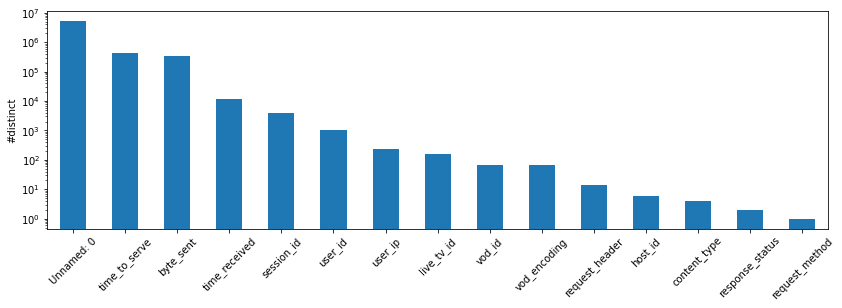

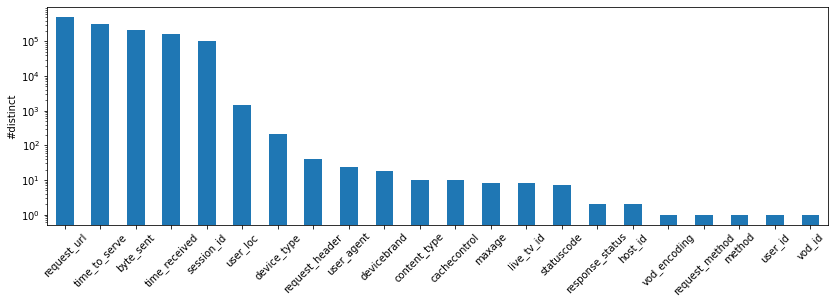

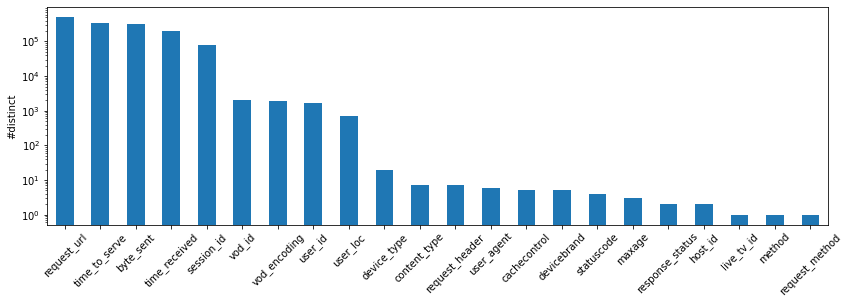

In [8]:
pltnunique(dfOld)
pltnunique(dfLive)
pltnunique(dfVoD)

## Relation between features

In [22]:
getMaxUnique(dfLive, 'request_url', 'live_tv_id') # 1:N
getMaxUnique(dfVoD, 'request_url', 'vod_id') # 1:N
getMaxUnique(dfLive, 'user_loc', 'host_id') # N:N
getMaxUnique(dfLive, 'request_url', 'host_id') # N:N
getMaxUnique(dfLive, 'request_url', 'content_type') # N:N
getMaxUnique(dfVoD, 'request_url', 'content_type') # N:N
getMaxUnique(dfLive, 'request_url', 'session_id') # N:N
getMaxUnique(dfLive, 'session_id', 'request_url') # N:N
getMaxUnique(dfLive, ['request_url', 'byte_sent'], 'content_type') # 1:N this is the new cache key 
getMaxUnique(dfVoD, 'vod_id', 'vod_encoding') # 1:1
getMaxUnique(dfVoD, 'vod_encoding', 'vod_id') # 1:1
getMaxUnique(dfOld, 'byte_sent', 'content_type') # 1:1

Relation between request_url live_tv_id is: 1
Relation between request_url vod_id is: 1
Relation between user_loc host_id is: 2
Relation between request_url host_id is: 2
Relation between request_url content_type is: 2
Relation between request_url content_type is: 2
Relation between request_url session_id is: 12817
Relation between session_id request_url is: 9150
Relation between ['request_url', 'byte_sent'] content_type is: 1
Relation between vod_id vod_encoding is: 1
Relation between vod_encoding vod_id is: 1
Relation between byte_sent content_type is: 2


## Traffic Analysis

Time Range: 2021-10-13 06:59:45 2021-10-13 10:14:48 #requests: 5261829
Time Range: 2021-11-13 06:59:04+00:00 2021-11-16 00:00:00+00:00 #requests: 2161721
Time Range: 2021-11-13 06:59:04+00:00 2021-11-16 00:00:00+00:00 #requests: 1577063


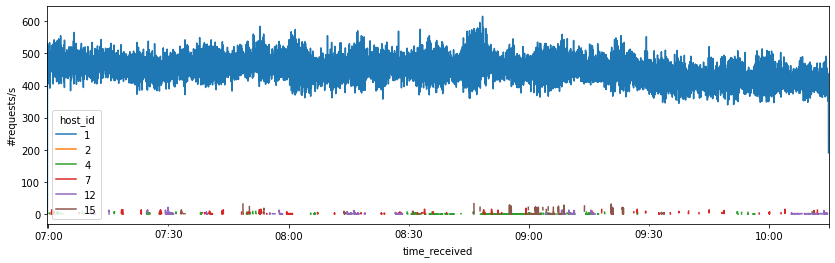

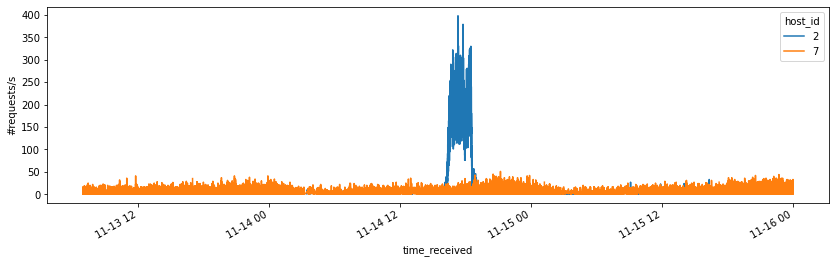

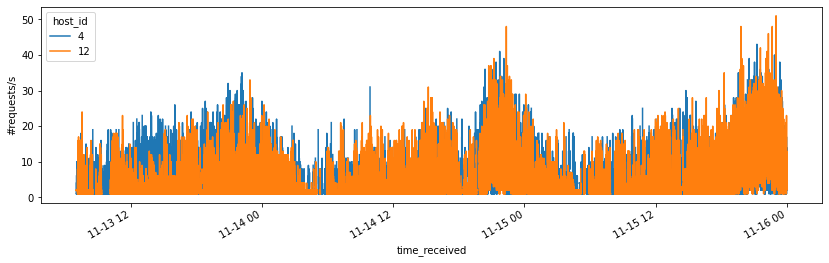

In [6]:
pltTraffic(dfOld)
pltTraffic(dfLive)
pltTraffic(dfVoD)

## dfs per host

In [5]:
dfDict= {}
dfDict['1']=filterHost(dfOld, 1)
dfDict['7']=filterHost(dfLive, 7)
dfDict['2']=filterHost(dfLive, 2)
dfDict['4']=filterHost(dfVoD, 4)
dfDict['12']=filterHost(dfVoD, 12)

## check delay

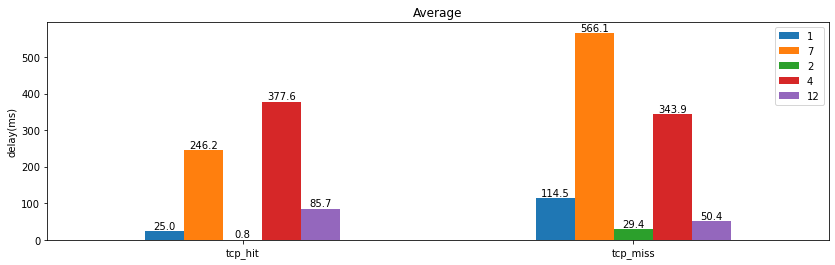

In [12]:
# mean()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].mean().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Average')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

In [14]:
#median()
dfBar=pd.DataFrame(index=['tcp_hit', 'tcp_miss'])
for key in dfDict:
    dfBar[key]= dfDict[key].groupby(['response_status'])['time_to_serve'].median().values
ax= dfBar.multiply(1000).plot.bar(figsize=(14,4), ylabel='delay(ms)',rot=0, title='Median')
for container in ax.containers:
    ax.bar_label(container, fmt='%0.1f')

## Check features connection with hit/miss

In [24]:
for key in dfDict:
    print(key)
    get_HR(dfDict[key])

1
response OHR:  74.85730612620944  BHR:  72.1884272986117 #requests 5253379
7
response OHR:  5.489888521651448  BHR:  4.917649356114116 #requests 589083
2
response OHR:  90.80037960248885  BHR:  92.67732626153453 #requests 1567956
4
response OHR:  60.1795328123734  BHR:  61.636516280961615 #requests 715858
12
response OHR:  23.305252524079634  BHR:  22.882792097412334 #requests 861205


1
How is everything related to hit\miss


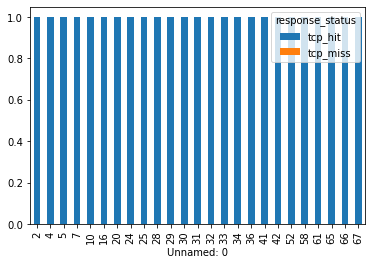

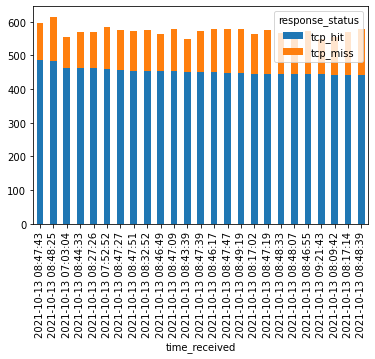

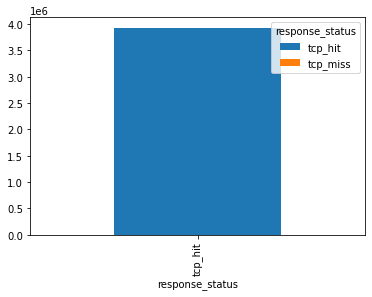

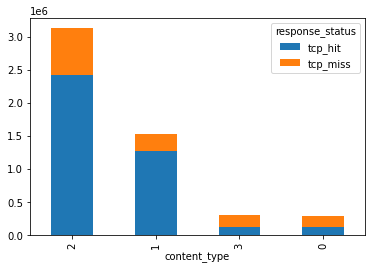

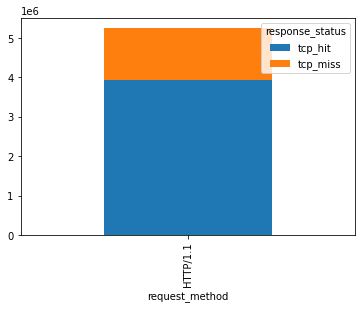

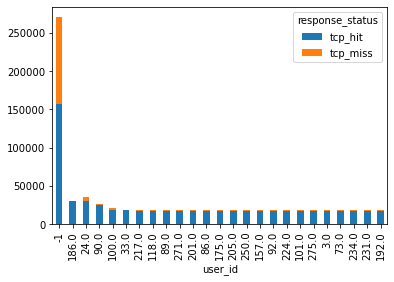

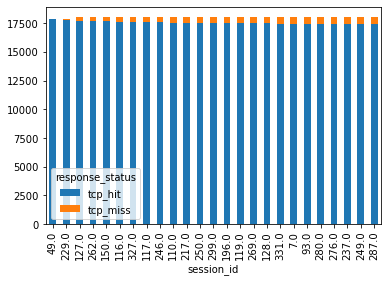

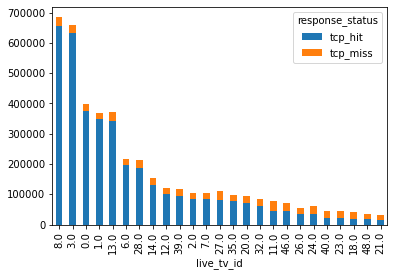

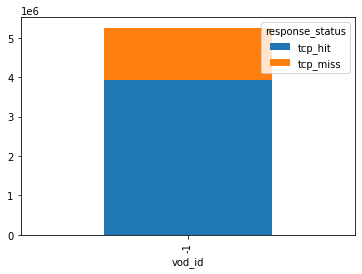

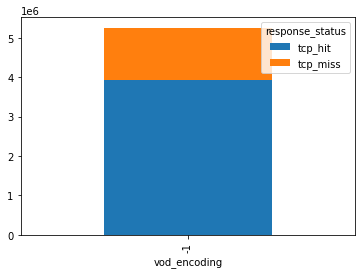

7
How is everything related to hit\miss


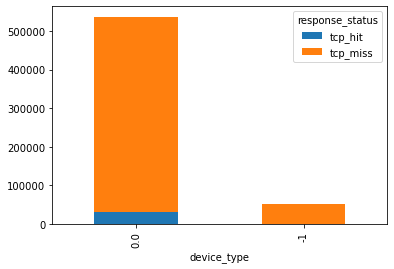

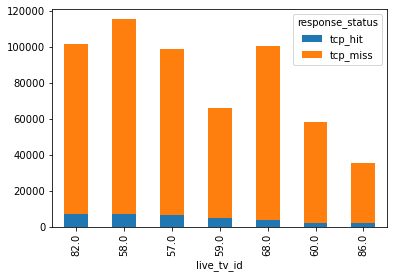

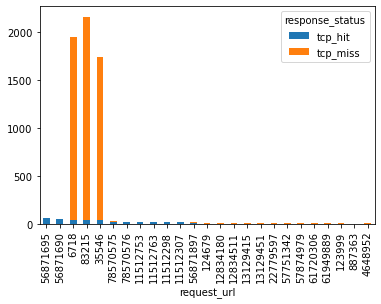

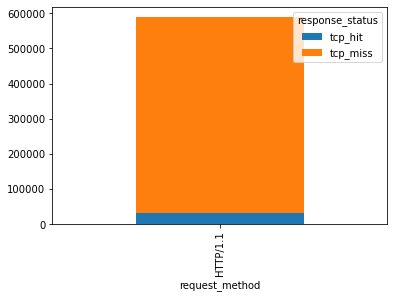

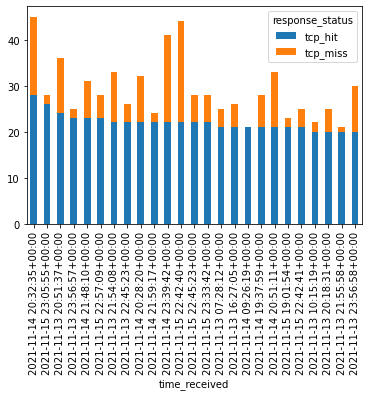

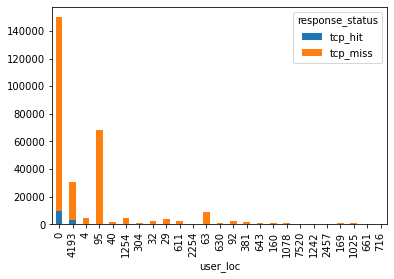

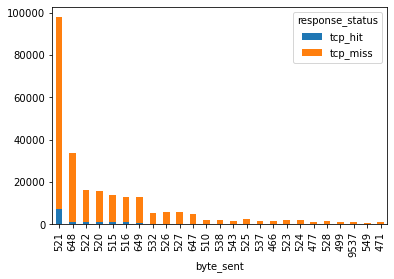

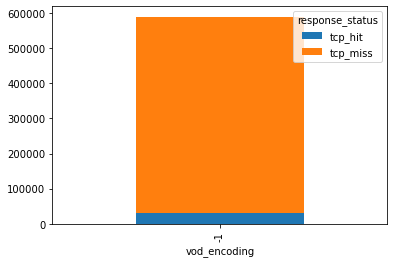

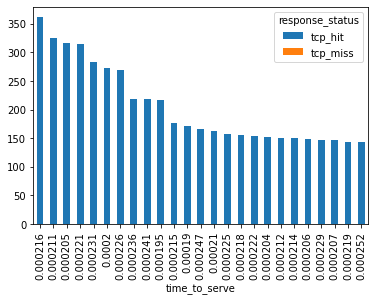

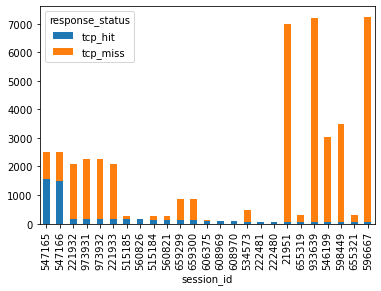

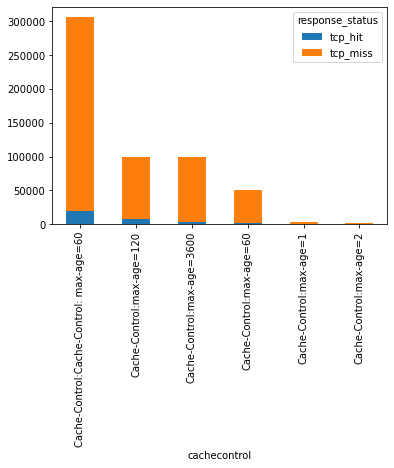

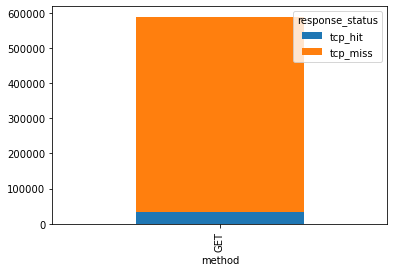

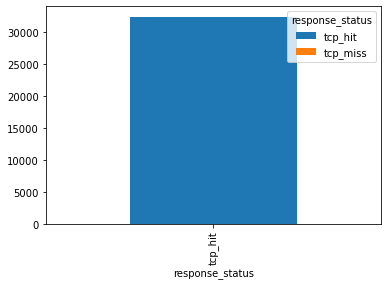

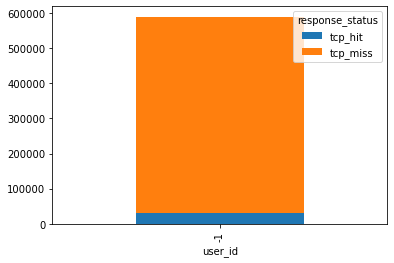

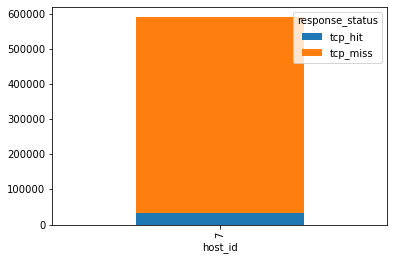

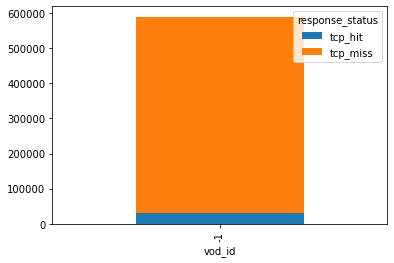

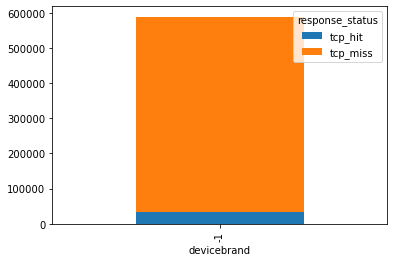

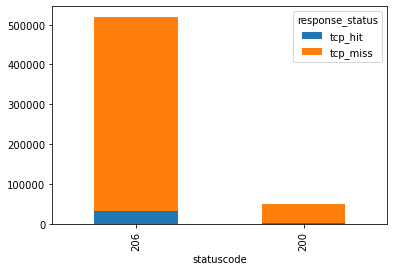

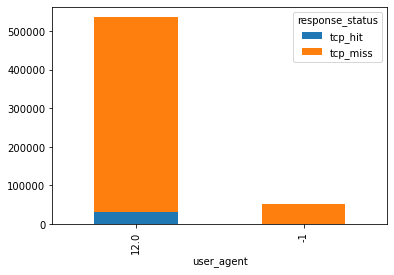

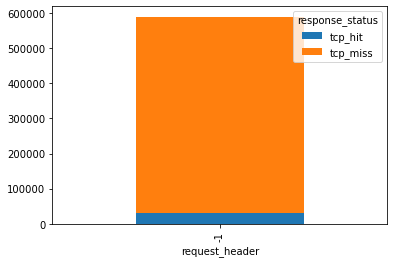

2
How is everything related to hit\miss


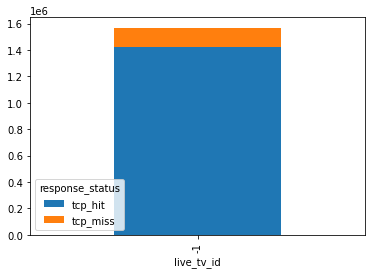

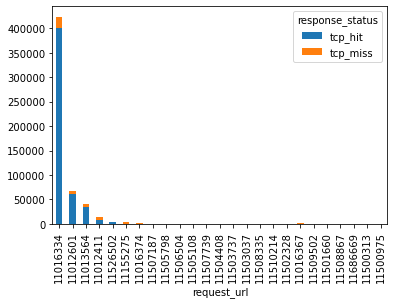

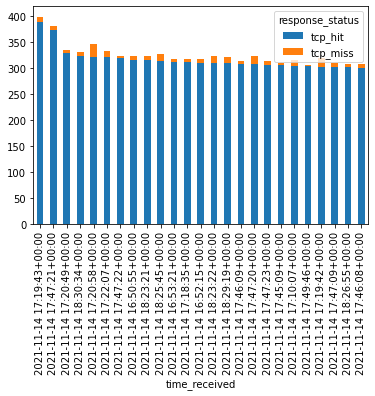

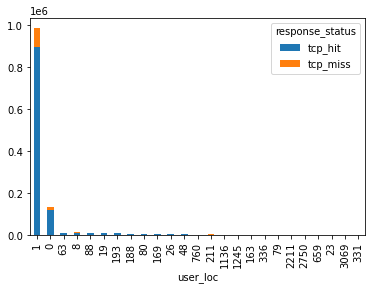

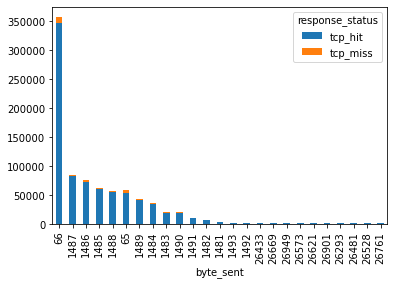

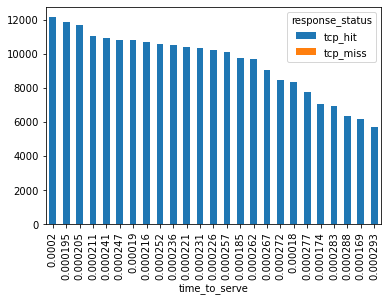

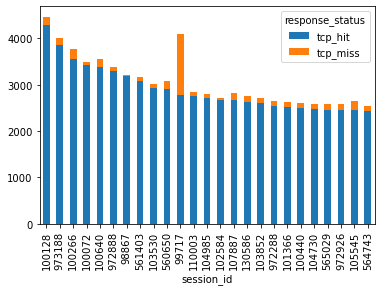

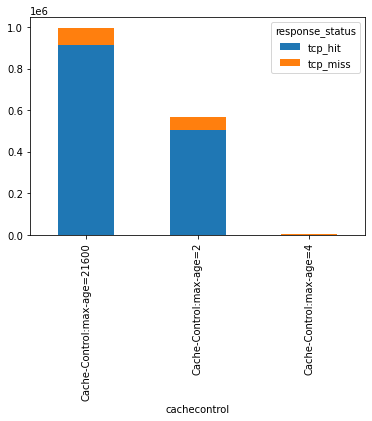

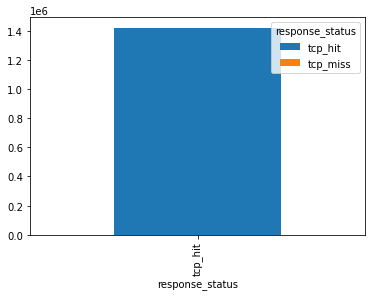

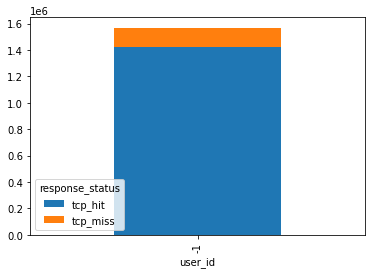

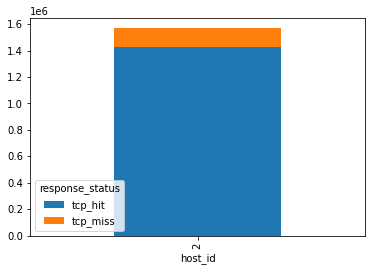

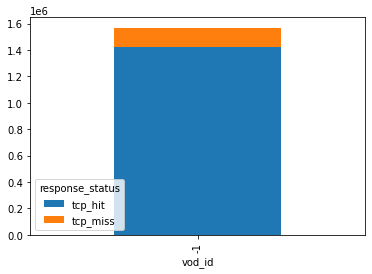

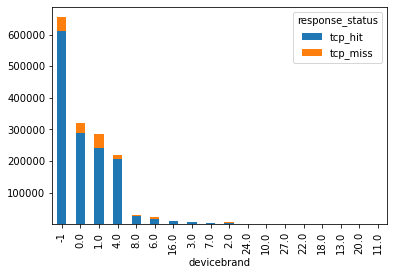

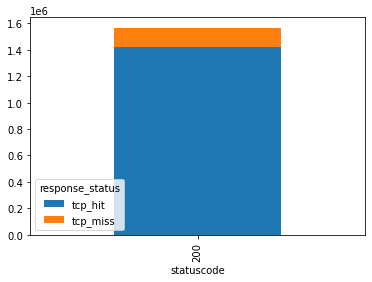

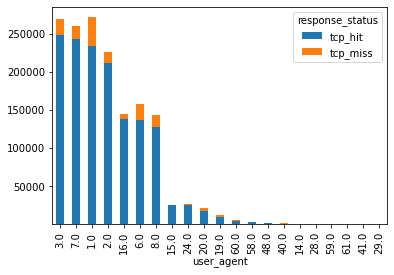

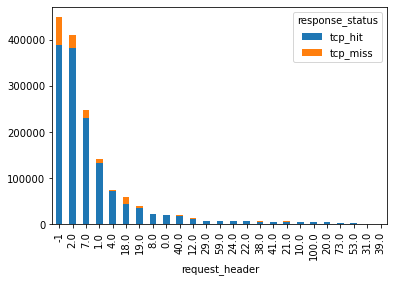

4
How is everything related to hit\miss


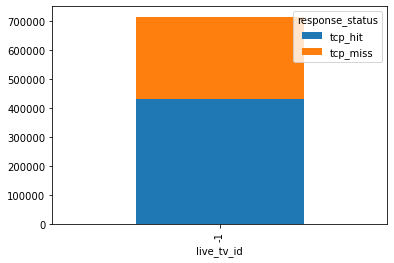

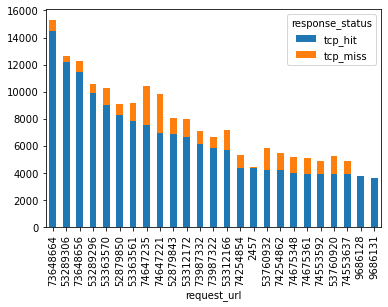

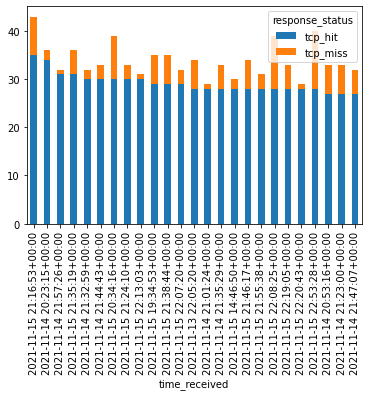

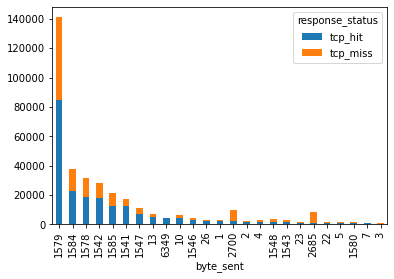

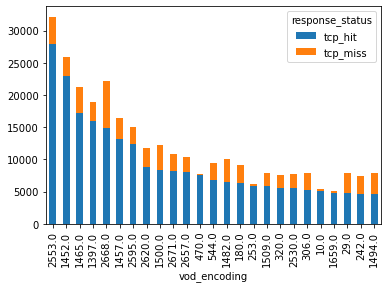

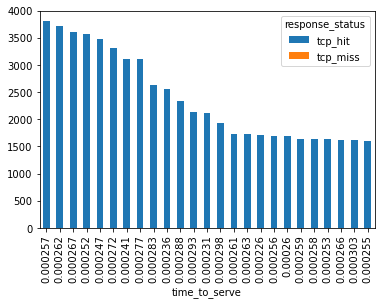

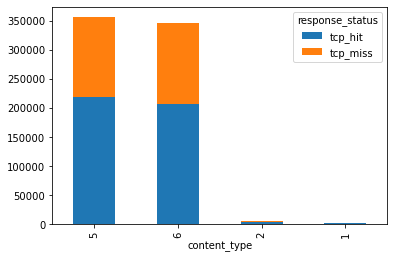

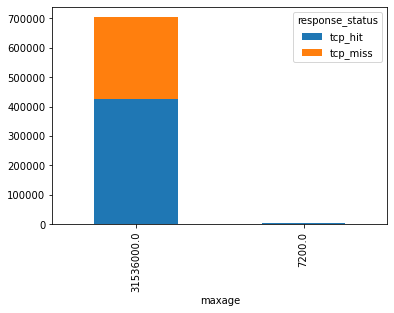

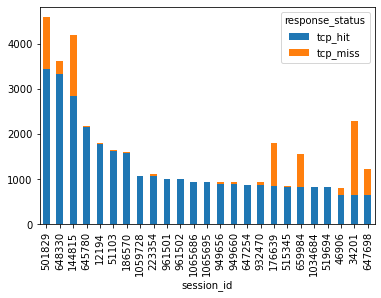

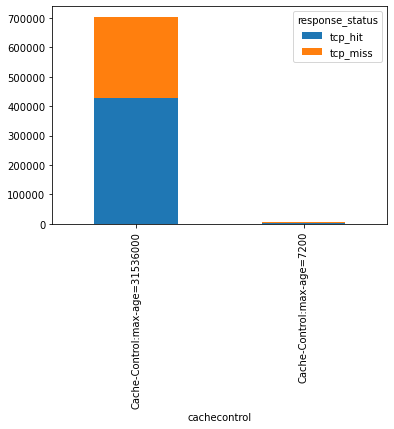

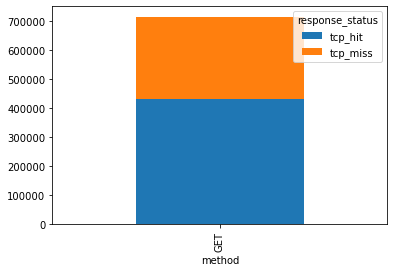

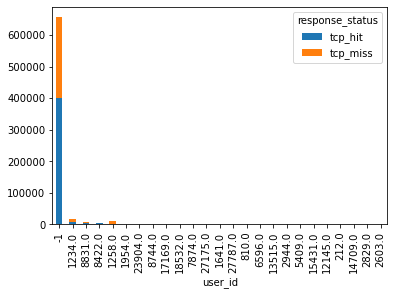

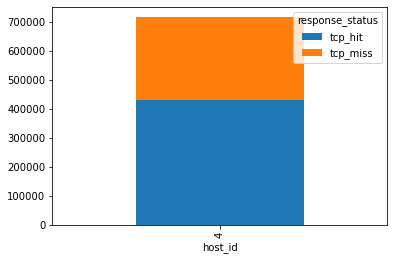

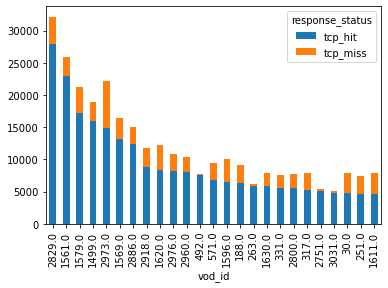

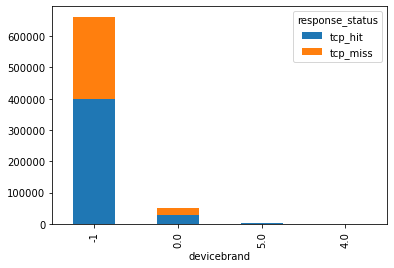

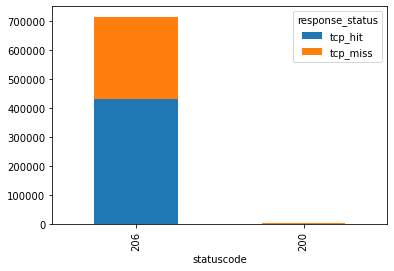

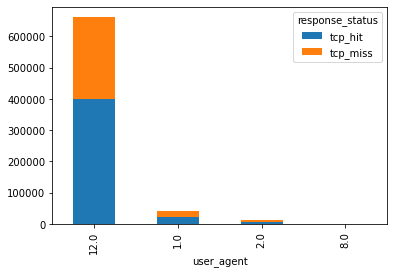

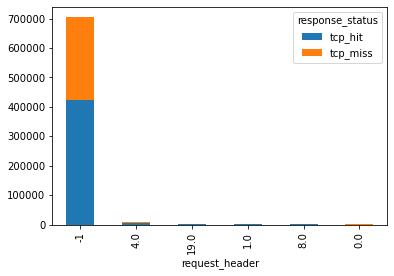

12
How is everything related to hit\miss


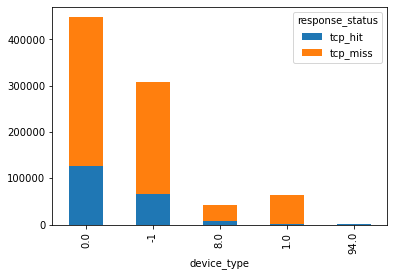

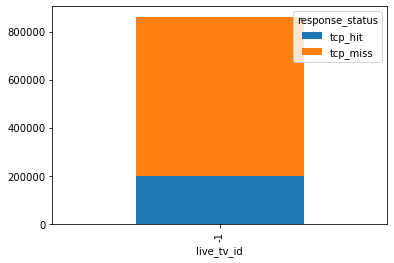

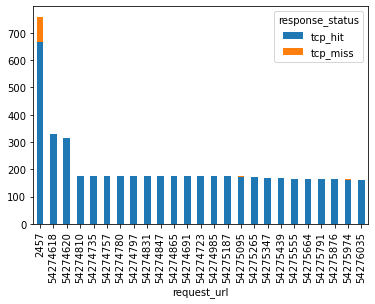

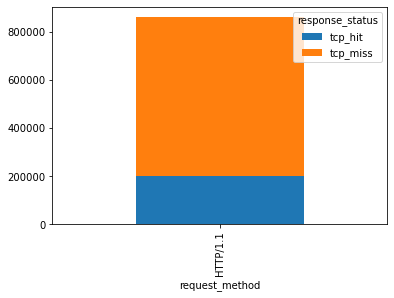

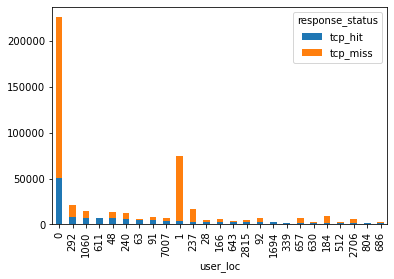

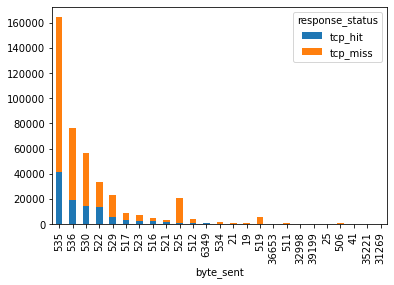

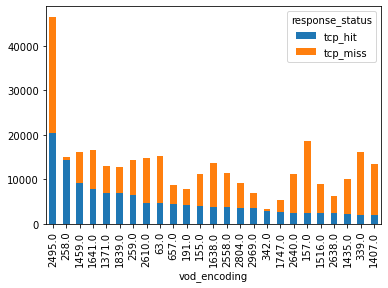

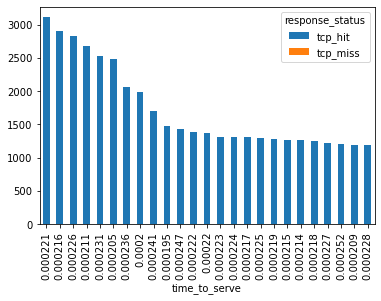

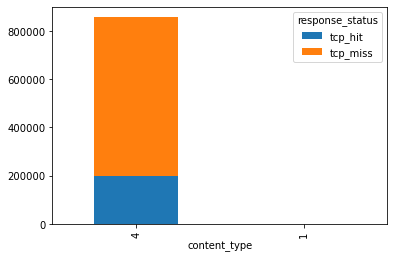

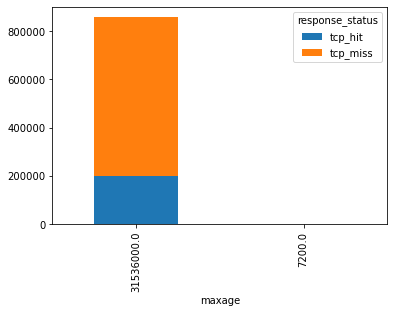

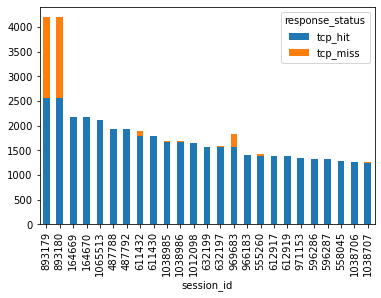

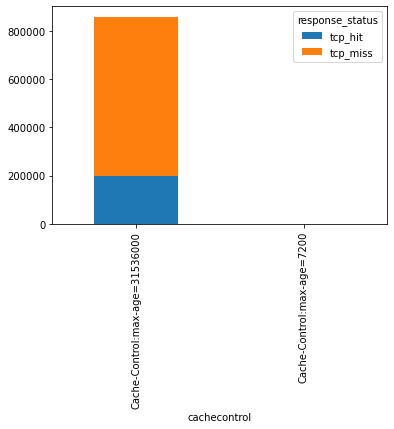

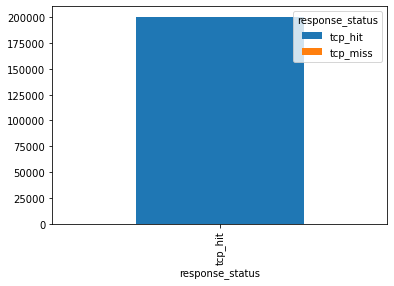

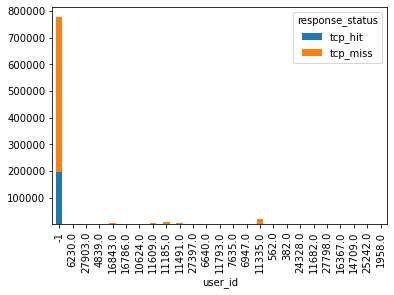

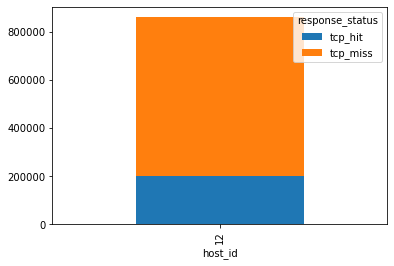

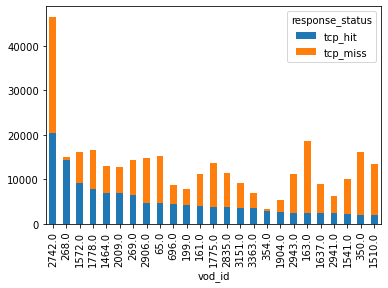

In [54]:
for key in dfDict:
    print(key)
    plotAll(dfDict[key])

We notice in new data that:
- most of the hits are when live-tv-id is nan- strange behavior
- new data has very few live-tv-id (7), not like old data
- no need to deeply preprocess content type, just encode it
- max age and Cache-Control:max-age seems similar, need to check
- What to do for hosts, they have different hit/miss behaviour
- max age null means don't cache (always miss)
- 206 Partial Content

## request size

1
7
2
4
12


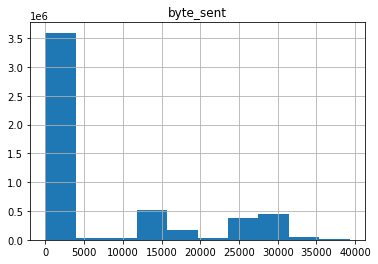

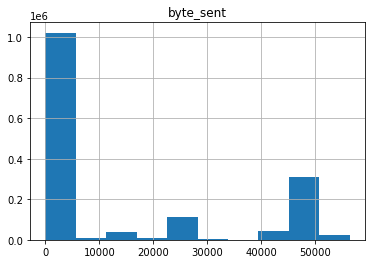

In [51]:
for key in dfDict:
    print(key)
    dfDict[key].hist("byte_sent")

# Preparation and preprocessing

## Delete zero size

In [8]:
for key in dfDict:
    dfDict[key]= deleteZeroByte(dfDict[key])

host:  1
#rows deleted: 7
host:  7
#rows deleted: 595
host:  2
#rows deleted: 4087
host:  4
#rows deleted: 0
host:  12
#rows deleted: 0


## content_type

In [9]:
for key in dfDict:
    dfDict[key]= encodeCol(dfDict[key], 'content_type')

## sorting by time

In [10]:
for key in dfDict:
    dfDict[key]= sortTime(dfDict[key])

# Caching

In [17]:
object_id_setM1= ['byte_sent', 'content_type', 'live_tv_id', 'vod_id'] # method 1
object_id_setM2= ['byte_sent', 'request_url'] # method 2
dfDict2= dfDict.copy() # method 2
del dfDict2['1'] # we can't use request_url for old data

In [22]:
# method1
print("Method1")
for key in dfDict:
    print(key)
    getNumUnique(dfDict[key], object_id_setM1)
    get_HR(dfDict[key])
           
# method2
print("Method2")
for key in dfDict2:
    print(key)
    getNumUnique(dfDict2[key], object_id_setM2)

Method1
1
5253379 281269 94.64594121231306
response OHR:  74.85730612620944  BHR:  72.1884272986117 #requests 5253379
7
589083 59515 89.89700941972524
response OHR:  5.489888521651448  BHR:  4.917649356114116 #requests 589083
2
1567956 13516 99.13798601491368
response OHR:  90.80037960248885  BHR:  92.67732626153453 #requests 1567956
4
715858 84234 88.2331412095695
response OHR:  60.1795328123734  BHR:  61.636516280961615 #requests 715858
12
861205 255477 70.33493767453743
response OHR:  23.305252524079634  BHR:  22.882792097412334 #requests 861205
Method2
7
589083 470014 20.212601619805703
2
1567956 52656 96.64174249787621
4
715858 86690 87.89005640783508
12
861205 507386 41.0841785637566


## Intial cache +  add object id + prepare for algo + export df

In [10]:
# method1
for key in dfDict:
    print("host: ", key)
    dfIntial= getIntialCache(dfDict[key], object_id_setM1)
    df= addObjectId(dfDict[key], dfIntial, object_id_setM1)
    df_algo= perpareForAlgo(df)
    df_algo.to_csv('../../Algo/lrb-master/M1host'+ str(key)+'.tr', index = False, header=False, sep=' ')

host:  1
#requests: 5253379
#cached requests 49470
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
#/% of distinct objects: 281268 5.354039752319411


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0      49470      29488
1     1      49471      26232
2     2      49472      28808
3     3      49473         31
4     4      49474      31422

host:  7
#requests: 589083
#cached requests 619
0
100000
200000
300000
400000
500000
#/% of distinct objects: 59514 10.102820824909223


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0        619       5694
1     1        620        449
2     2        621       5521
3     3        622          2
4     4        623         30

host:  2
#requests: 1567956
#cached requests 1668
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
#/% of distinct objects: 13515 0.8619502077864429


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       1668         67
1     1       1668         67
2     2       1668         67
3     3       1668         67
4     4       1668         67

host:  4
#requests: 715858
#cached requests 14262
0
100000
200000
300000
400000
500000
600000
700000
#/% of distinct objects: 84233 11.766719097921655


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      54437
1     1          1       1295
2     2          2       1546
3     3          3          1
4     4          4          1

host:  12
#requests: 861205
#cached requests 7987
0
100000
200000
300000
400000
500000
600000
700000
800000
#/% of distinct objects: 255476 29.664946209090754


/tmp/ipykernel_30/937159735.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      31037
1     1          1        530
2     2          2      41530
3     3          3        535
4     4          4      33120

In [17]:
# method2
for key in dfDict2:
    print("host: ", key)
    dfIntial= getIntialCache(dfDict[key], object_id_setM2)
    df= addObjectId( dfDict[key], dfIntial, object_id_setM2)
    df_algo= perpareForAlgo(df)
    df_algo.to_csv('../../Algo/lrb-master/M2host'+ str(key)+'.tr', index = False, header=False, sep=' ')

host:  7
#requests: 589083
#cached requests 4516
0
100000
200000
300000
400000
500000
#/% of distinct objects: 470013 79.78722862482876


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       4516       5694
1     1       4517        449
2     2       4518       5521
3     3       4519          2
4     4       4520         30

host:  2
#requests: 1567956
#cached requests 5230
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
#/% of distinct objects: 52655 3.358193724823911


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0       5230         67
1     1       5230         67
2     2       5230         67
3     3       5230         67
4     4       5230         67

host:  4
#requests: 715858
#cached requests 14480
0
100000
200000
300000
400000
500000
600000
700000
#/% of distinct objects: 86689 12.109803899656077


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      54437
1     1          1       1295
2     2          2       1546
3     3          3          1
4     4          4          1

host:  12
#requests: 861205
#cached requests 15291
0
100000
200000
300000
400000
500000
600000
700000
800000
#/% of distinct objects: 507385 58.91570531987158


/tmp/ipykernel_30/1966143607.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_algo['time']= df_algo.index


time  object_id  byte_sent
0     0          0      31037
1     1          1        530
2     2          2      41530
3     3          3        535
4     4          4      33120

## Run all algos for all hosts Don't Run

In [ ]:
from subprocess import PIPE, run, check_output
import os

def runAlgos(name, size, method):
    print(name, size, method)
    pwd= os.getcwd()
    algos= ["Random","Inf","Belady","RelaxedBelady","AdaptSize","LRU","ThLRU","LeCaR","UCB","LRB"]
    outf = open("../../DSL2/Results/"+ str(method) + str(name)+ "-" + str(size)+ ".json", "w+")
    outf.write("[")
    for algo in algos:
        os.system("docker rm $(docker ps -a -q  --filter ancestor=sunnyszy/webcachesim)")
        p = check_output(['docker', 'run', '-it', '-v', pwd+':/trace', 'sunnyszy/webcachesim', str(method) + str(name)+".tr", algo, str(size)])
        st=p.decode("utf-8")
        start= st.find("trace_file")
        end= st.find("segment_rss")
        outf.write(st[start-3:end-3])
        outf.write("}")
        if algo != algos[-1]:
            outf.write(",")
        print(algo+ " Done")
        
    outf.write("]") 


names= [1, 7,2,4,12]
sizes= range(int(1e8),int(2e9),int(3e8))
method= "M1host"

for name in names:
    for size in sizes:
        runAlgos(name, size, method)
    
# docker run -it -v ${PWD}:/trace sunnyszy/webcachesim host2.tr LRU 100000000 > LRU-v.txt



## Reading results after running

Host 1
response OHR:  74.85720638079898  BHR:  72.18869167610089 #requests 5253386
100000000


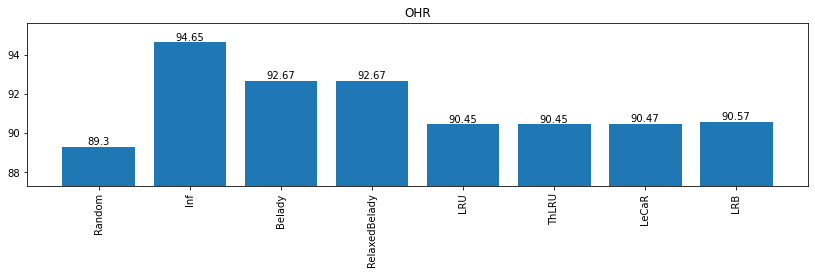

400000000


700000000


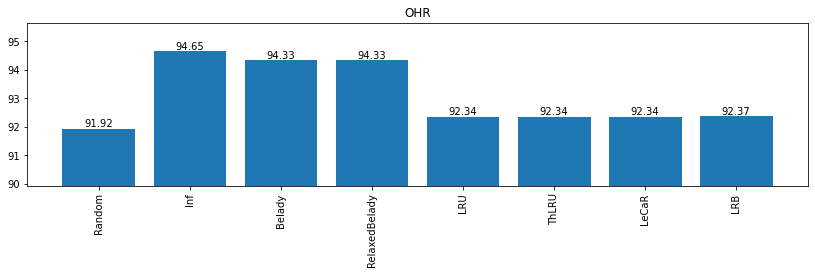

1000000000


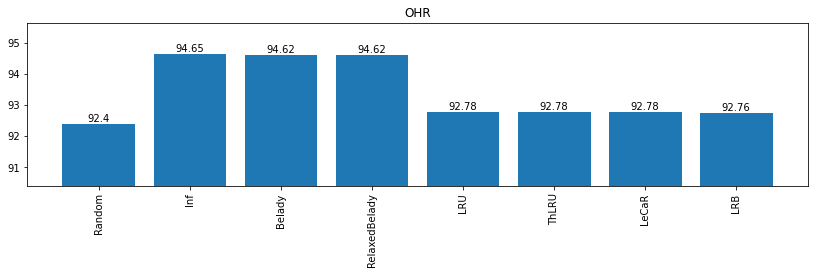

1300000000


1600000000


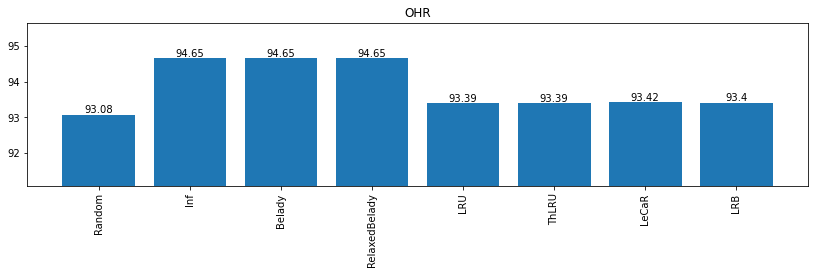

1900000000


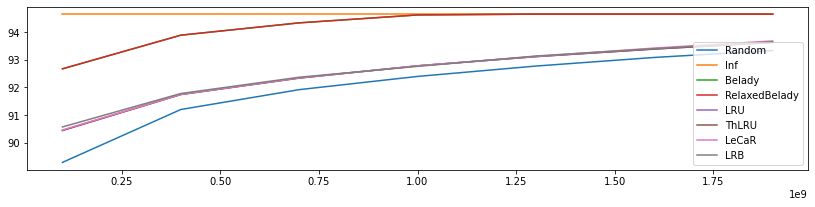

Host 7
response OHR:  5.484349085433067  BHR:  4.9176978507226154 #requests 589678
100000000


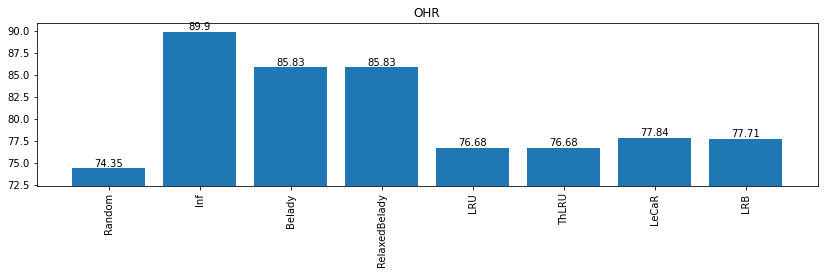

400000000


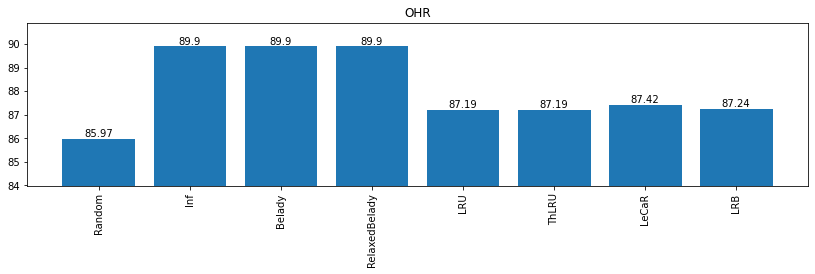

700000000


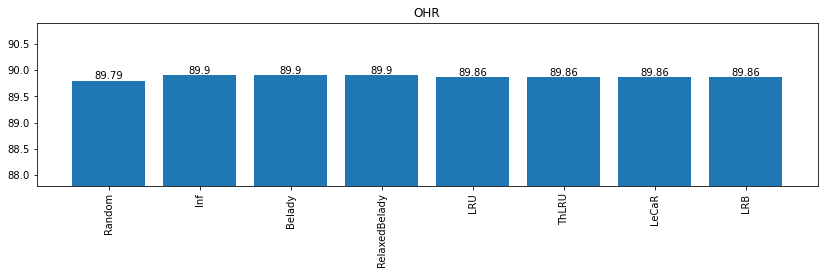

1000000000


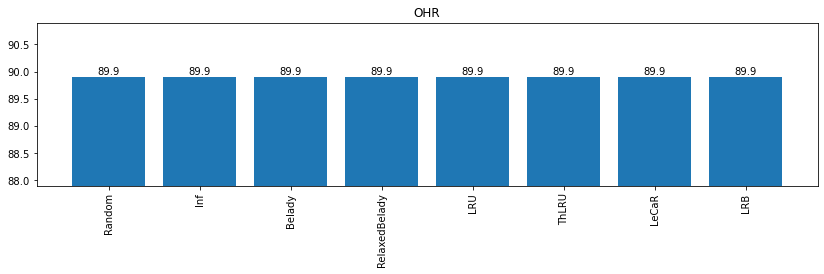

1300000000


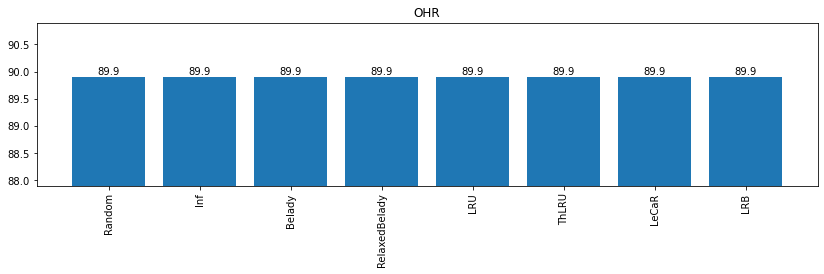

1600000000


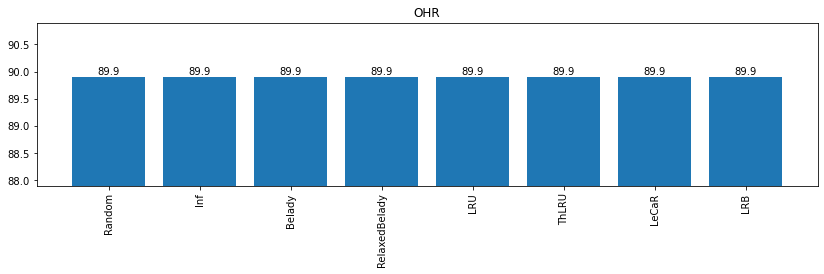

1900000000


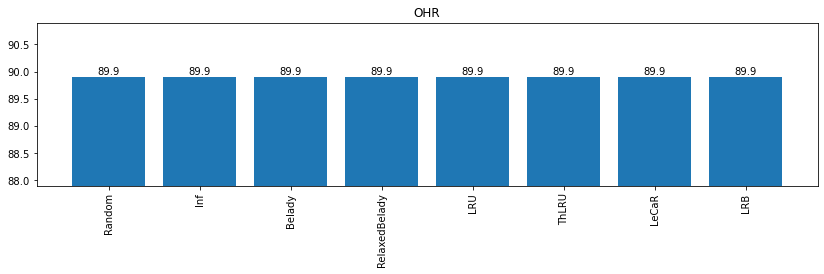

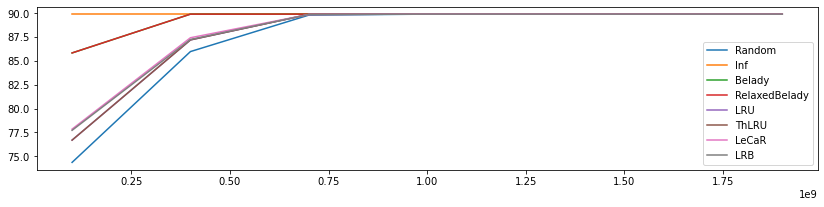

Host 2
response OHR:  90.56431662492692  BHR:  92.67721945227353 #requests 1572043
100000000


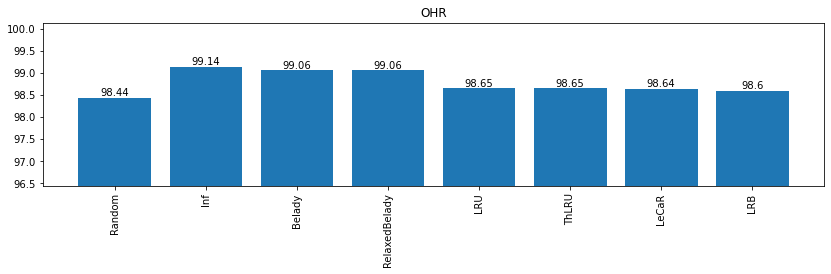

400000000


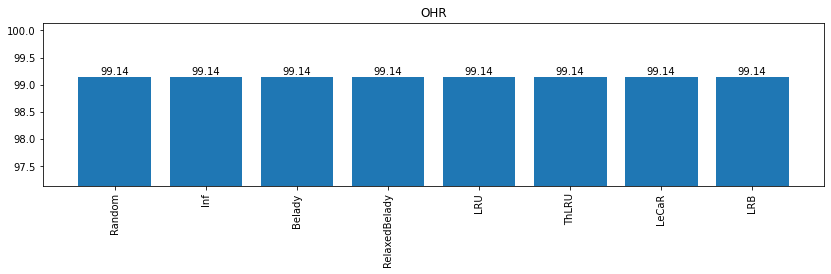

700000000


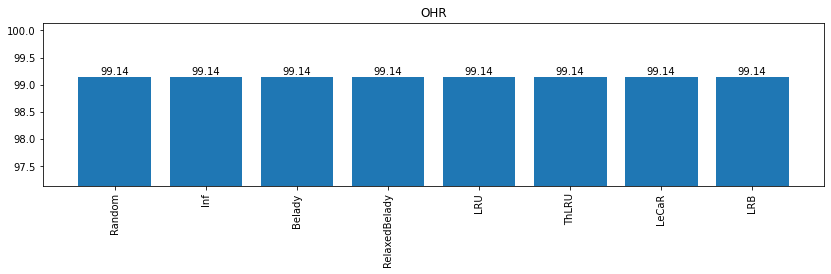

1000000000


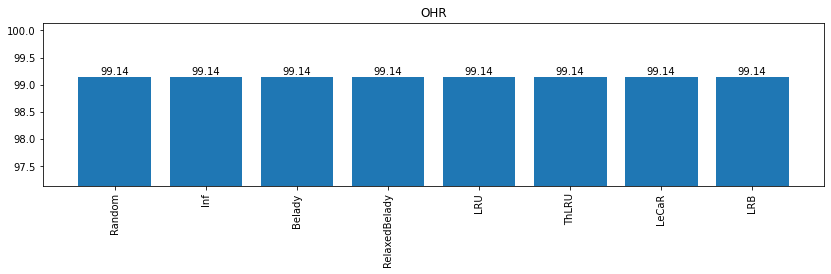

1300000000


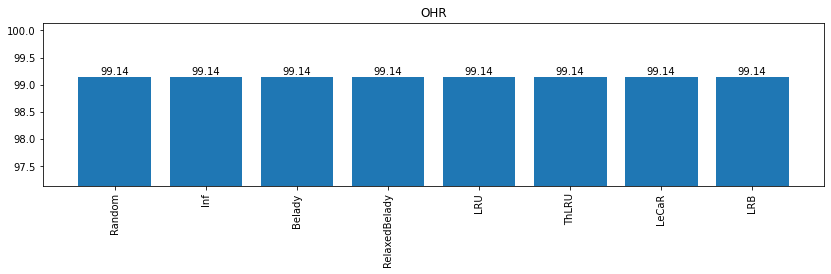

1600000000


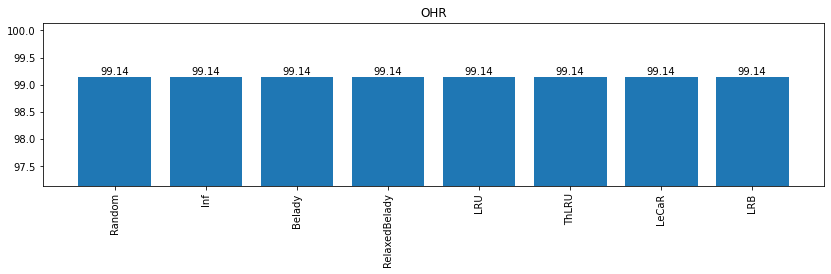

1900000000


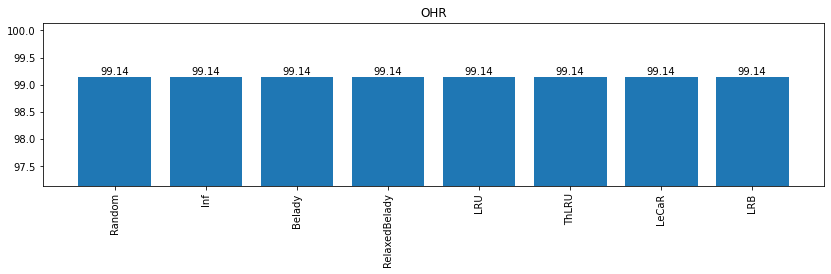

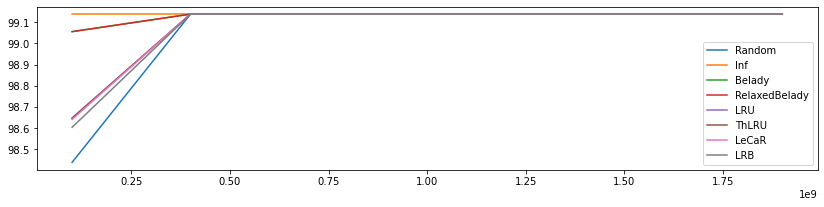

Host 4
response OHR:  60.1795328123734  BHR:  61.63648524199482 #requests 715858
100000000


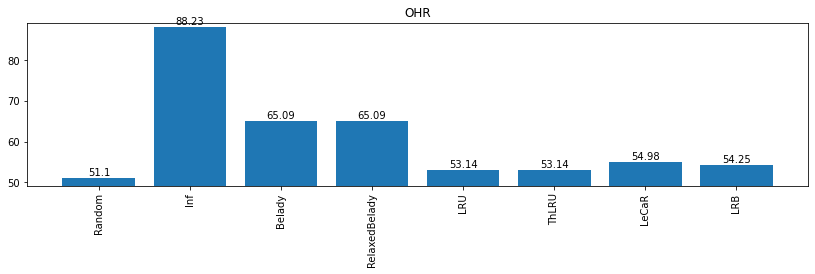

400000000


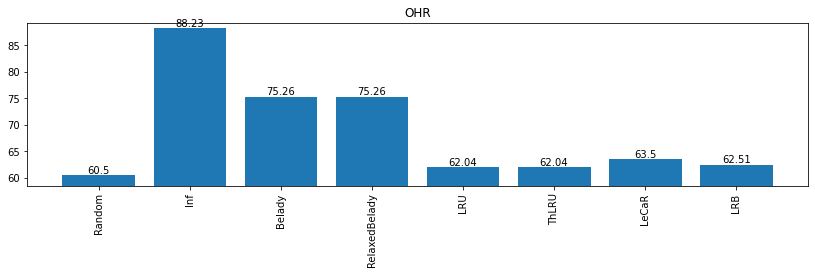

700000000


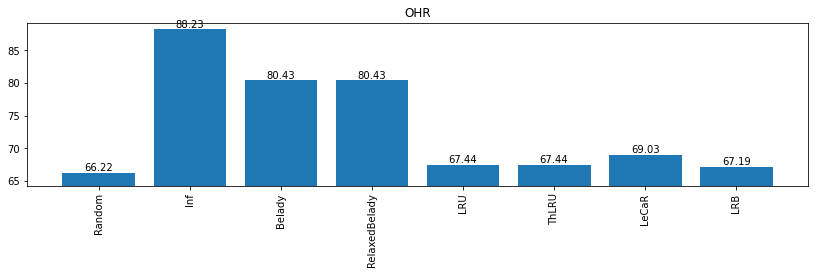

1000000000


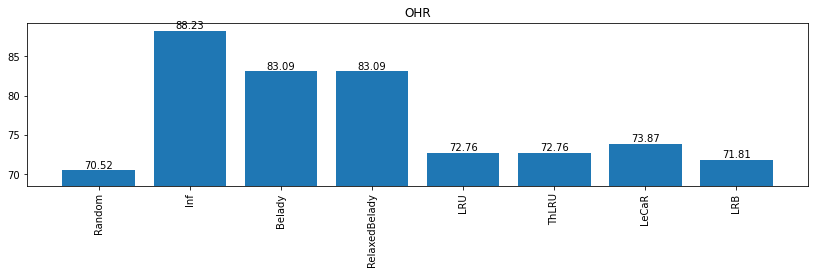

1300000000


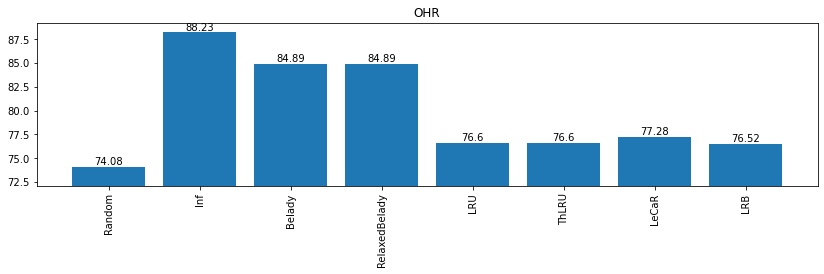

1600000000


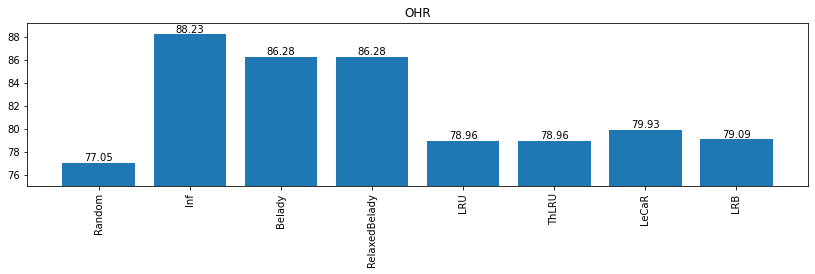

1900000000


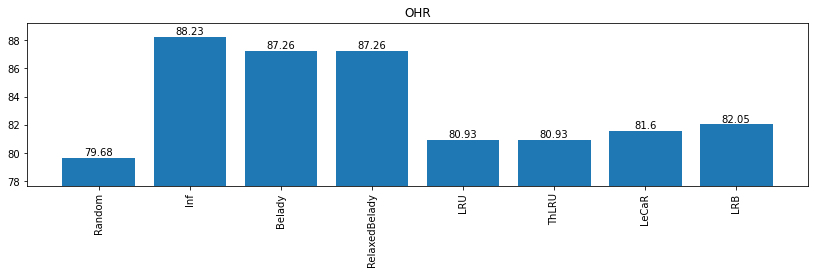

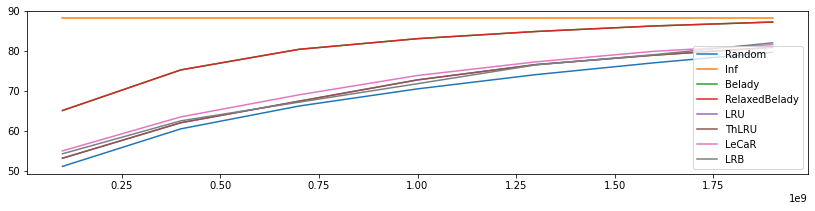

Host 12
response OHR:  23.305252524079634  BHR:  22.882814417081292 #requests 861205
100000000


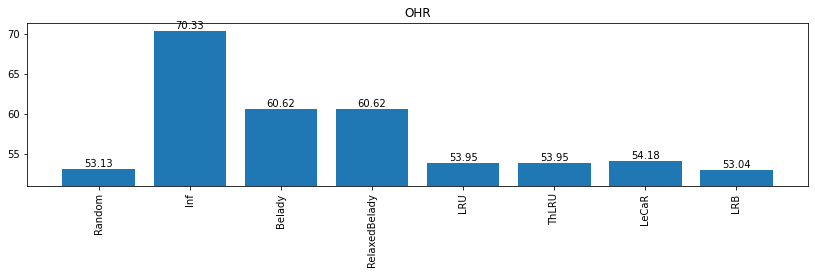

400000000


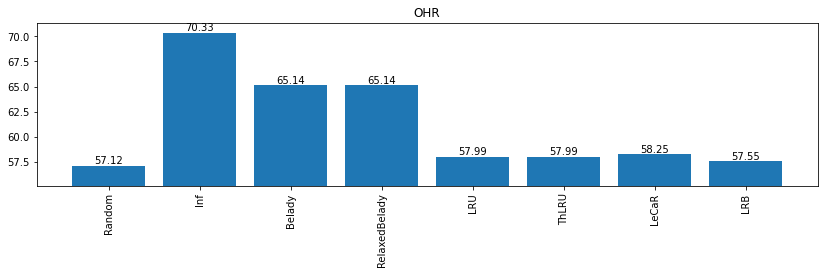

700000000


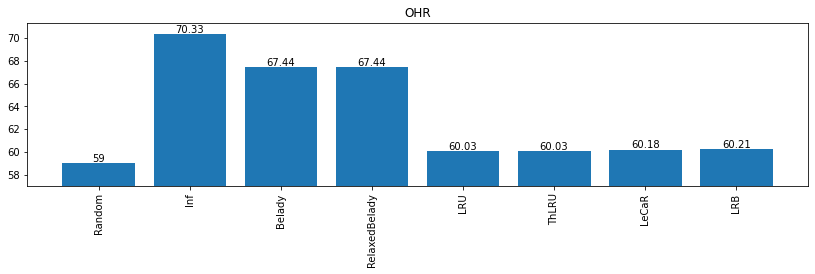

1000000000


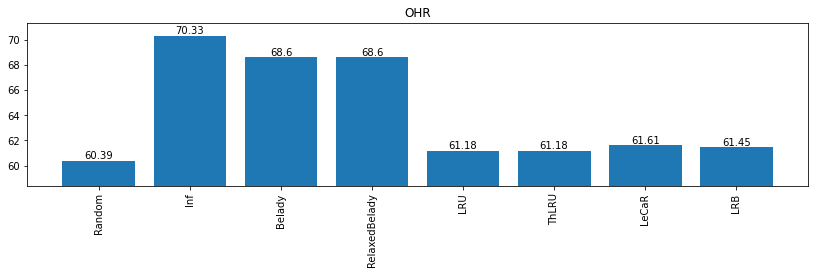

1300000000


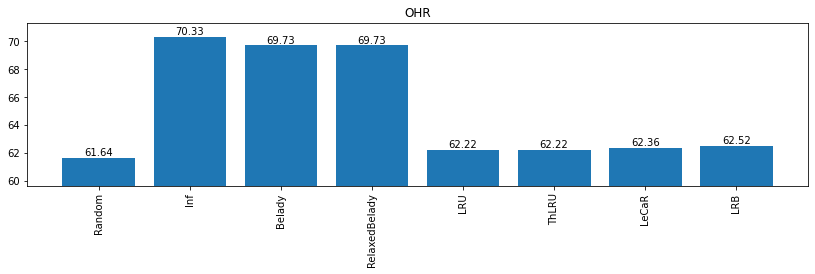

1600000000


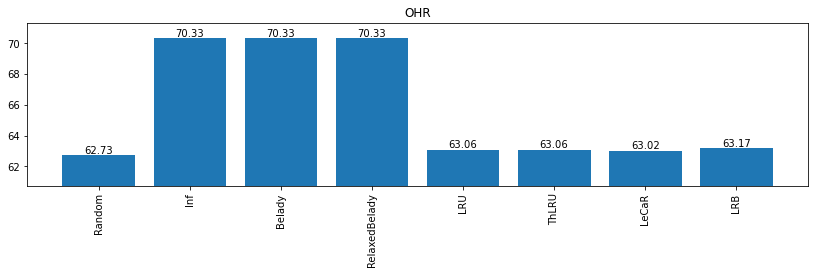

1900000000


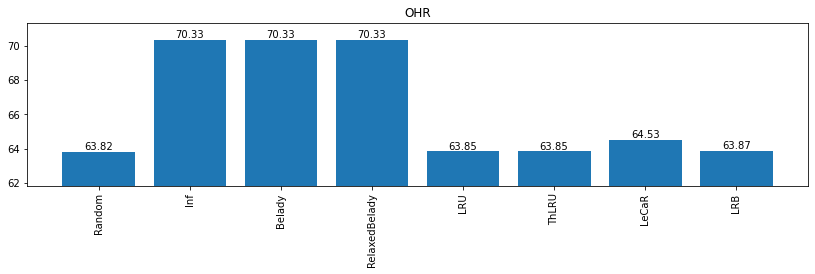

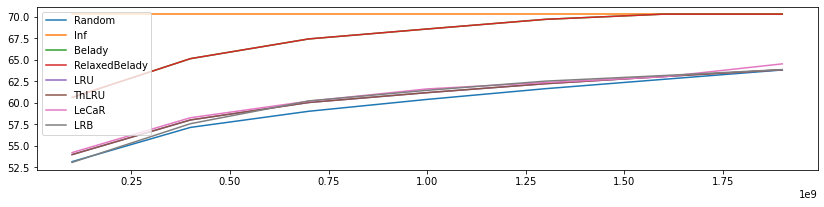

In [19]:
sizes= range(int(1e8),int(2e9),int(3e8))
algos= ["Random","Inf","Belady","RelaxedBelady","LRU","ThLRU","LeCaR","LRB"]
for key in dfDict:
    print("Host", key)
    OHRD={}
    for item in algos:
        OHRD[item]=[]
    get_HR(dfDict[key])
    for size in sizes: 
        print(size)
        f = open('../Results/M1host'+ str(key)+ "-" + str(size)+ '.json')
        data = json.load(f)
        OHR={}
        BHR={}
        for item in data:
            if item['cache_type']!="AdaptSize" and item['cache_type']!="UCB":
                OHR[item['cache_type']], BHR[item['cache_type']]=   getHitRatesAlgo(item)
                OHRD[item['cache_type']].append(OHR[item['cache_type']])
        pltDict(OHR, "OHR")
        #pltDict(BHR, "BHR")
    figure(figsize=(14,3))
    for keyp in OHRD:
        plt.plot(sizes, OHRD[keyp])
    plt.legend(algos)
    plt.show()

Host 7
response OHR:  5.484349085433067  BHR:  4.9176978507226154 #requests 589678
100000000


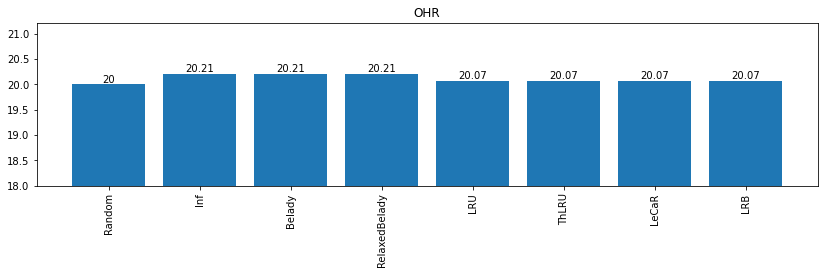

400000000


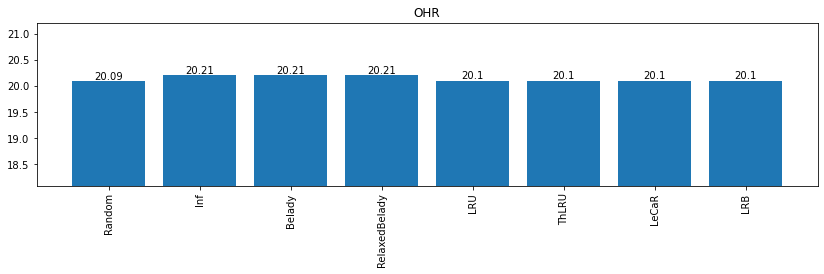

700000000


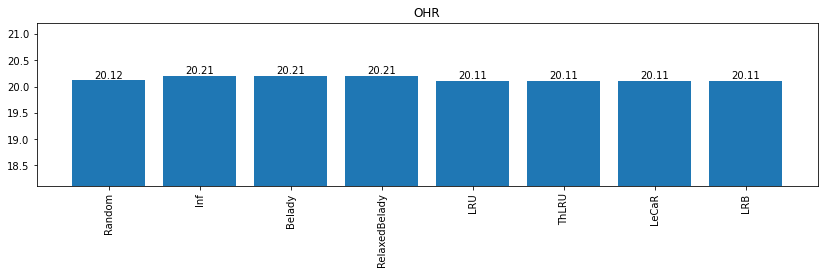

1000000000


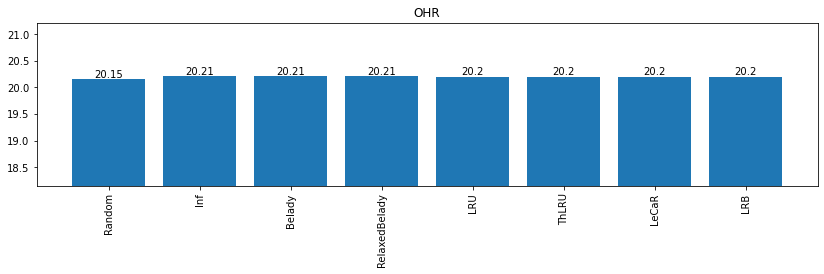

1300000000


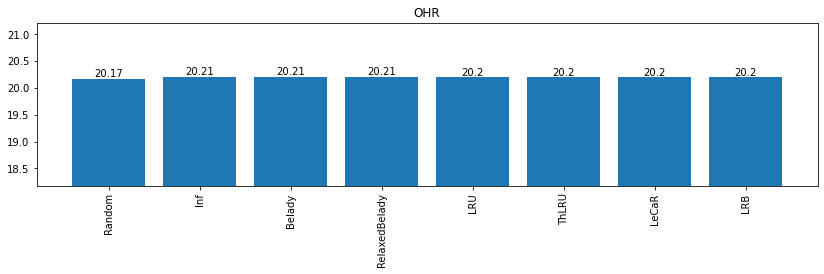

1600000000


1900000000


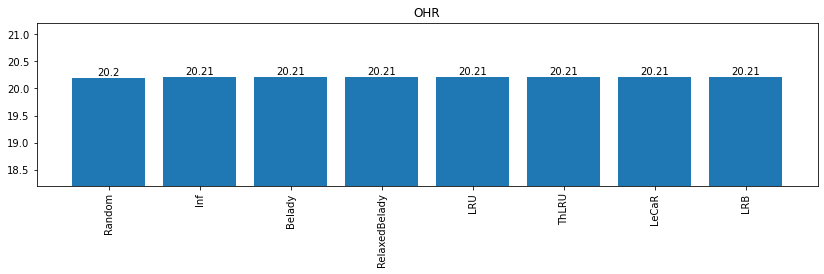

Host 2
response OHR:  90.56431662492692  BHR:  92.67721945227353 #requests 1572043
100000000


400000000


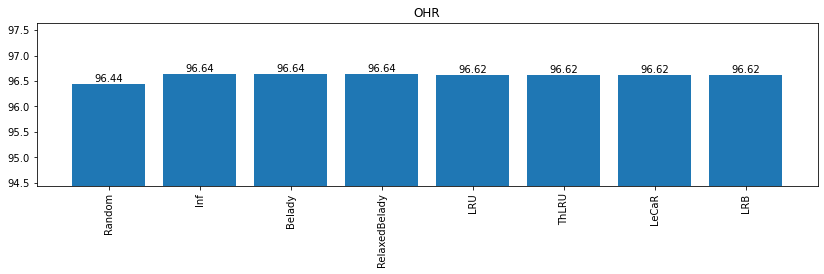

700000000


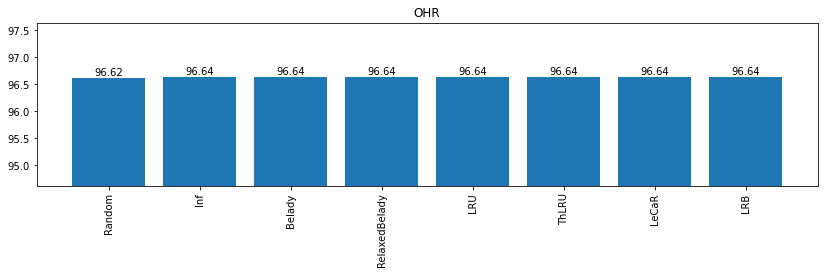

1000000000


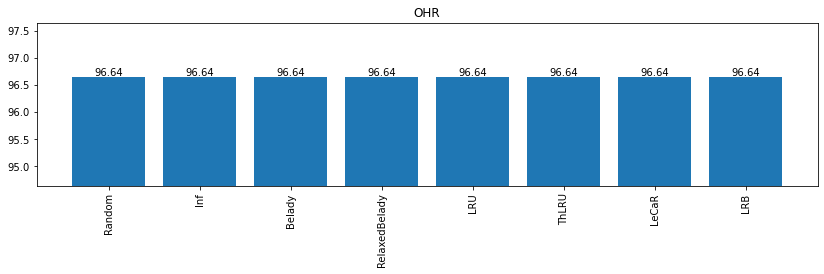

1300000000


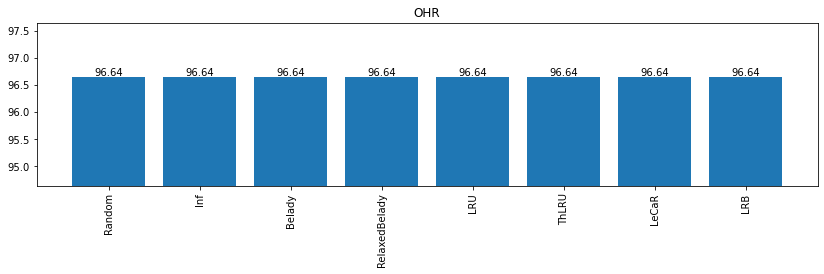

1600000000


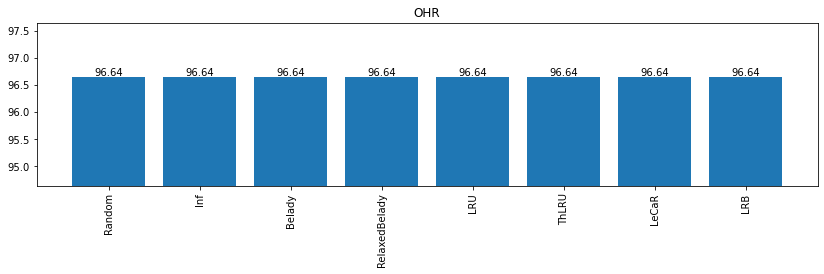

1900000000


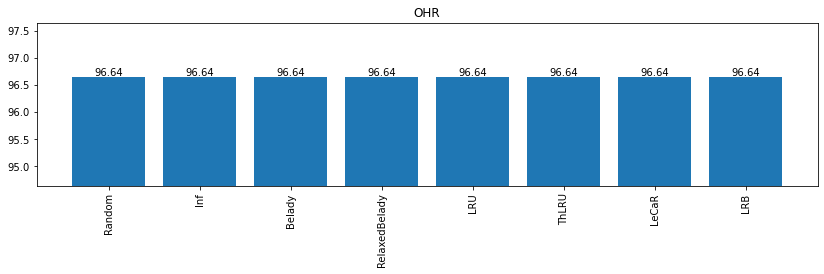

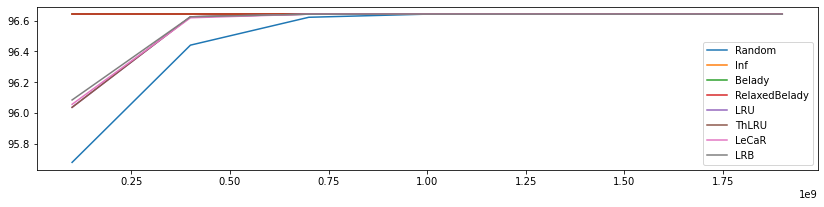

Host 4
response OHR:  60.1795328123734  BHR:  61.63648524199482 #requests 715858
100000000


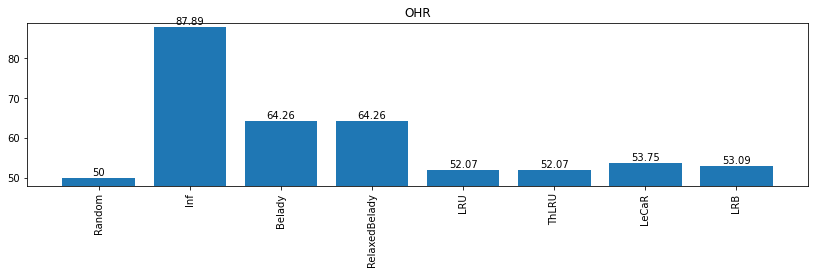

400000000


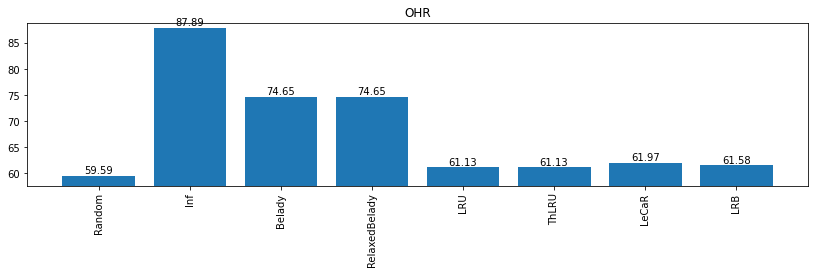

700000000


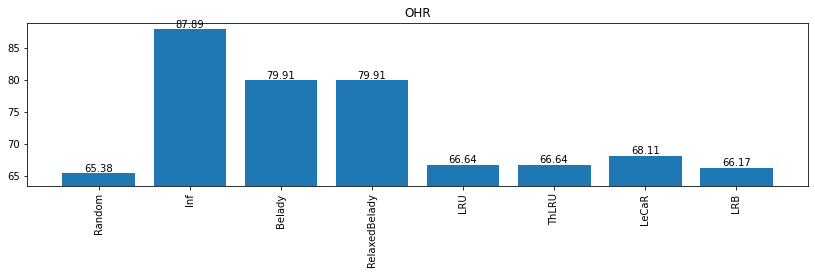

1000000000


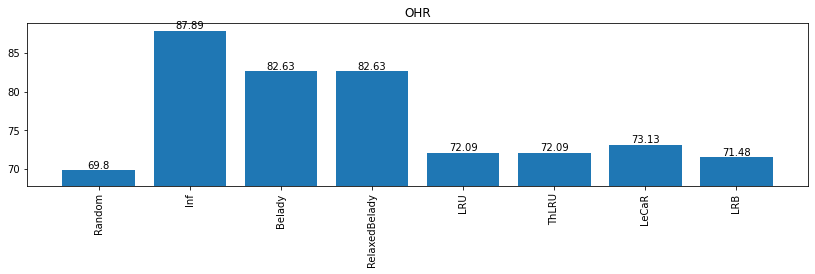

1300000000


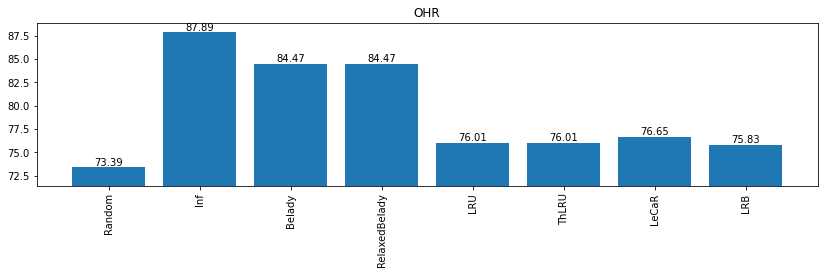

1600000000


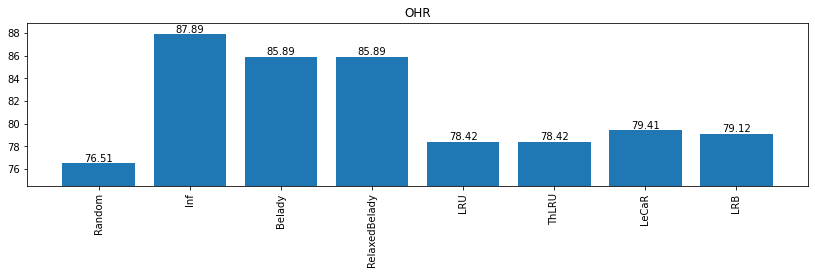

1900000000


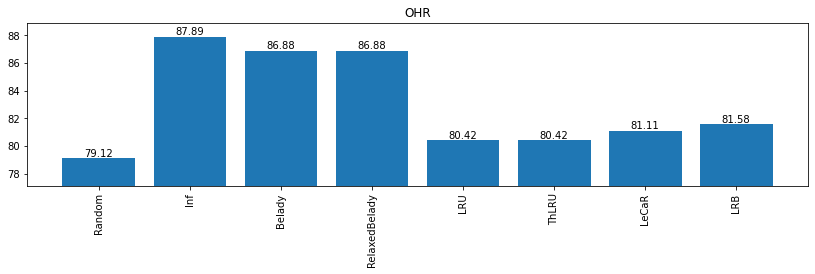

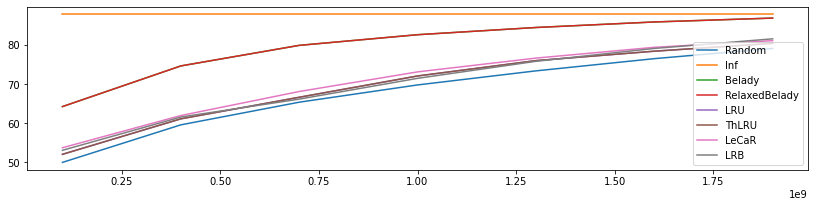

Host 12
response OHR:  23.305252524079634  BHR:  22.882814417081292 #requests 861205
100000000


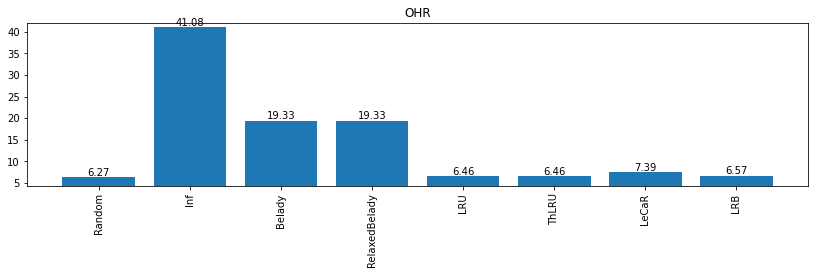

400000000


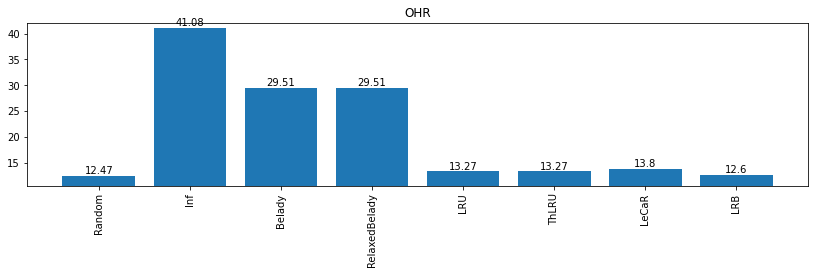

700000000


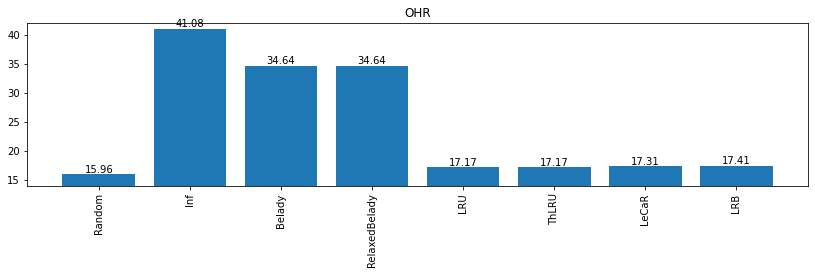

1000000000


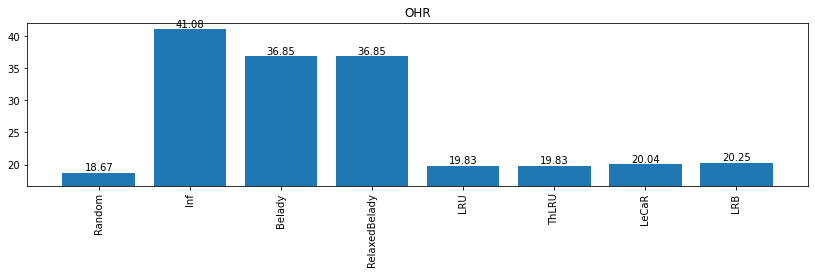

1300000000


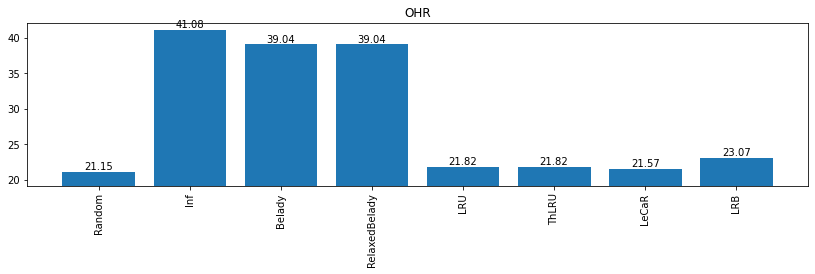

1600000000


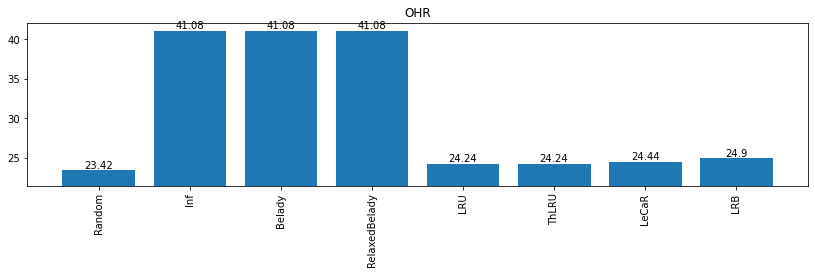

1900000000


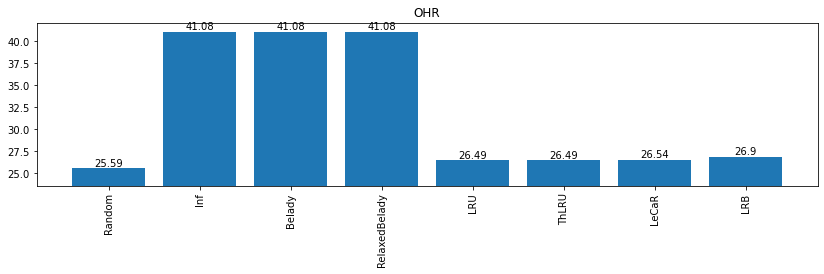

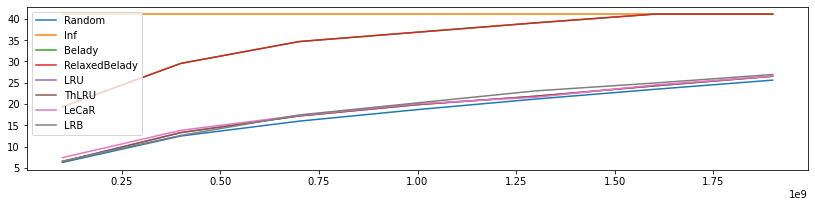

In [18]:
sizes= range(int(1e8),int(2e9),int(3e8))
algos= ["Random","Inf","Belady","RelaxedBelady","LRU","ThLRU","LeCaR","LRB"]
for key in dfDict2:
    print("Host", key)
    OHRD={}
    for item in algos:
        OHRD[item]=[]
    get_HR(dfDict[key])
    for size in sizes: 
        print(size)
        f = open('../Results/M2host'+ str(key)+ "-" + str(size)+ '.json')
        data = json.load(f)
        OHR={}
        BHR={}
        for item in data:
            if item['cache_type']!="AdaptSize" and item['cache_type']!="UCB":
                OHR[item['cache_type']], BHR[item['cache_type']]=   getHitRatesAlgo(item)
                OHRD[item['cache_type']].append(OHR[item['cache_type']])
        pltDict(OHR, "OHR")
        #pltDict(BHR, "BHR")
    figure(figsize=(14,3))
    for keyp in OHRD:
        plt.plot(sizes, OHRD[keyp])
    plt.legend(algos)
    plt.show()